In [1]:
from collections import defaultdict
from scipy.stats import pearsonr, spearmanr, kendalltau

import pandas as pd 
import numpy as np
import joblib
import os

import matplotlib.pyplot as plt
import seaborn as sns

Process the baseline results at both **system-level** and **instance-level**. We will measure the performance at the **dev** and **test sets**. Note that every model/experiment decision, should only rely on the results available for **dev** set. 

In [2]:
def flatten_summ(dataset: dict) -> list:
    """
    {
        "doc_id": {
            "src": "This is the source text.",
            "ref_summ": "This is the reference summary",
            "sys_summs": {
                "sys_name1": {
                    "sys_summ": "This is the system summary.",
                    "scores": {
                        "human_metric1": 0.3,
                        "human_metric2": 0.5
    }}}}}
    """
    flattened = []
    
    for doc_id, doc_data in dataset.items():
        for sys_name, sys_data in doc_data["sys_summs"].items():
            data = {
                "bartscore_doc_id": doc_id,
                "src": doc_data["src"],
                "ref_summ": doc_data["ref_summ"],
                "sys_name": sys_name,
                "sys_summ": sys_data["sys_summ"],
            }
            
            data.update({f"{col}": score for col, score in sys_data["scores"].items()})
            flattened.append(data)
    return flattened


def read_scores_data(dataset_name, parent_dir, **_):
    data: dict = joblib.load(f"{parent_dir}/{dataset_name}_scores.pkl")
    data = flatten_summ(data)
    data = pd.DataFrame(data).reset_index()
    
    for col in ("bert_score_p", "bert_score_r", "bert_score_f"):
        if col in data.columns:
            data[col] = data[col].apply(float)
    
    return data

However, we need to filter the results based on the dev and test splits.

In [3]:
def get_eval_ids(dataset_name, dataset_classes, parent_dir, splits=("dev", "test"), **_):
    split_ids = {}

    for split in splits:
        filepath = f"{parent_dir}/{dataset_name}/{dataset_classes}_{split}.csv"
        data_split = pd.read_csv(filepath)

        ids = sorted(data_split["bartscore_doc_id"].unique())
        split_ids[split] = ids
        
    return split_ids


def filter_by_ids(data: pd.DataFrame, ids_list: list):
    return data[data["bartscore_doc_id"].isin(ids_list)]

System- and instance-level correlations are useful to compare the baselines.

### Instance-level correlation

Compute the correlation between the metric values for all instances in the dataset. That is for each instance i, compute the metric value assigned to all generated summaries of system 1..j. Repeat with a second metric. Measure their correlation. Average the correlation over the different instances in the dataset.

In [4]:
def _get_instance_level_correlation(data: pd.DataFrame, metrics: list, target_col: str, corr_method: callable) -> dict:
    name = corr_method.__name__
    print("Computing", name, "with", target_col, "col")
    
    # Pseudo algorithm
    # 1. Iterate over each doc_id
    # 2. Compute the correlation between different metric values for each doc_id and the human values
    # 3. Avg correlation coefficients in the end
    instance_level_corrs = defaultdict(list)

    for iid in data["bartscore_doc_id"].unique():
        for m in metrics:
            instance = data[data["bartscore_doc_id"] == iid]

            corr, p_val = corr_method(instance[m], instance[target_col])
            instance_level_corrs[m].append(corr)
           
    # Compute the avg (#TODO - handle p_val)
    instance_level_corrs_avg = {metric: np.mean(corr_data) for metric, corr_data in instance_level_corrs.items()}
    return instance_level_corrs_avg

def compute_instance_level_correlations(data, metrics, target_col, dataset_name, output_dir, to_persist=True, **_):
    correlations = {}
    for corr_method in (pearsonr, spearmanr, kendalltau):
        result = _get_instance_level_correlation(data, metrics, target_col, corr_method)

        correlations[corr_method.__name__] = result

    correlations = pd.DataFrame(correlations)
    if to_persist:
        os.makedirs(output_dir, exist_ok=True)
        correlations.reset_index().to_csv(f"{output_dir}/{dataset_name}_instance_corrs.csv", index=0)
    
    return correlations

### System-level correlation

Compute the correlation between the avg values assigned by the two metrics to each system.


In [5]:
def _get_system_level_correlation(data, metrics, target_col, systems, corr_method: callable) -> dict:
    # pseudo code
    # for each system
    # compute the mean score attributed by a metric m to the outputs of each system.
    # compute the mean score attributed by a target_col to the outputs of each system.
    # compute correlation
    system_level_correlation = defaultdict(list)
    for sys in systems:
        data_sys = data[data["sys_name"] == sys]
        # ^Note: since we're computing the mean, we dont need to ensure the ordering

        for m in metrics + [target_col]:
            mean_sys = data_sys[m].mean()
            system_level_correlation[m].append(mean_sys)

    # Compute the correlation now
    correlations = {}
    for m in metrics:
        corr, p_val = corr_method(system_level_correlation[m], system_level_correlation[target_col])

        correlations[m] = round(corr, 4)

    return correlations


def compute_system_level_correlations(data, metrics, target_col, dataset_name, systems, output_dir, to_persist=True, **_):

    correlations = {}
    for corr_method in (pearsonr, spearmanr, kendalltau):
        result = _get_system_level_correlation(data, metrics, target_col, systems, corr_method)
        correlations[corr_method.__name__] = result

    correlations = pd.DataFrame(correlations)
    if to_persist:
        os.makedirs(output_dir, exist_ok=True)
        correlations.reset_index().to_csv(f"{output_dir}/{dataset_name}_system_corrs.csv", index=0)
    
    return correlations

### Get T0 baselines

In [131]:
from glob import glob


def get_t0_baselines(dataset_name: str, dataset_classes: str, parent_dir: str, output_dir="./t-few-master/exp_out", **_kwargs):
    def extract_name(path: str) -> str:
        # Given a path in the format
        # './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train/<something>
        # 1. Extract the parent dir `t03b_realsumm_baseline_ft_train`
        exp_name = path.split("/")[-2]
        
        # 2. Keep all parts including baseline and afterwards
        index_baseline = exp_name.index("baseline")
        return exp_name[index_baseline:]
        
    
    output_dir = f"{output_dir}/{dataset_name.lower()}"
    t0_baselines = "t03b_*_baseline*"
    
    dev_files = glob(os.path.join(output_dir, t0_baselines, "dev_pred.txt"))
    print(f"Find {len(dev_files)} experiments fit into {t0_baselines}")
    print("\t -->", "\n\t --> ".join(dev_files))
    print()
        
    test_files = glob(os.path.join(output_dir, t0_baselines, "test_pred.txt"))
    print(f"Find {len(test_files)} experiments fit into {t0_baselines}")
    print("\t -->", "\n\t --> ".join(test_files))
    print()
    
    # The result of the files will be:
    # ['./t-few-master/exp_out/realsumm/t03b_realsumm_baseline/dev_pred.txt',
    #  './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train/dev_pred.txt',
    # './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train_20k_steps/dev_pred.txt', 
    # './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_all/dev_pred.txt',
    # './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_all_20k_steps/dev_pred.txt'
    # ]
    # As such, we will extract the name of the baseline using the `extract_name` method, 
    # e.g., `baseline`, `baseline_ft_train`, `baseline_ft_train_20k_steps`, ...
    dev_data = {extract_name(path): pd.read_csv(path) for path in dev_files}
    test_data = {extract_name(path): pd.read_csv(path) for path in test_files}

    # Before returning the dataframe, we will recover the bartscore_doc_id
    # to facilitate re-use of previous correlation methods.
    dev_original_df = pd.read_csv(f"{parent_dir}/{dataset_name}/{dataset_classes}_dev.csv")[["index", "sys_name", "bartscore_doc_id"]]
    test_original_df = pd.read_csv(f"{parent_dir}/{dataset_name}/{dataset_classes}_test.csv")[["index", "sys_name", "bartscore_doc_id"]]
    
    dev_corpora = {}
    for baseline, data in dev_data.items():
        data = data.merge(dev_original_df, left_on="idx", right_on="index")
        dev_corpora[baseline] = data
    
    test_corpora = {}
    for baseline, data in test_data.items():
        data = data.merge(test_original_df, left_on="idx", right_on="index")
        test_corpora[baseline] = data
        
    print("Baselines (for dev):\n ->", list(dev_corpora.keys()))
    print("Baselines (for test):\n ->", list(test_corpora.keys()))
    return dev_corpora, test_corpora


# note: only applicable to results from 
def compute_split_correlations(
    split, 
    split_baselines, 
    dataset_split, 
    dataset_name, 
    dataset_classes, 
    parent_dir, 
    output_dir, 
    target_col, 
    systems, 
    tag="t0_baselines",
    **_
):
    instance_baseline_corrs = []
    system_baseline_corrs = []
        
    for baseline, data in split_baselines.items():
        print("-" * 80)
        print("Computing correlations for", baseline)
        print("-" * 80)

        d = dataset_split[["bartscore_doc_id", "sys_name", target_col]]
        ds = data.merge(d, on=["sys_name", "bartscore_doc_id"], how="inner")

        instance_corr = compute_instance_level_correlations(
            ds,
            metrics=["log.scores_class_1"],
            target_col=target_col,
            dataset_name=f"{dataset_name.lower()}_{baseline}",
            output_dir="",
            to_persist=False,
        )

        system_corr = compute_system_level_correlations(
            ds, 
            metrics=["log.scores_class_1"],
            target_col=target_col,
            dataset_name=f"{dataset_name.lower()}_{baseline}",
            output_dir="",
            systems=systems,
            to_persist=False
        )

        instance_corr["index"] = baseline
        system_corr["index"] = baseline

        instance_baseline_corrs.append(instance_corr)
        system_baseline_corrs.append(system_corr)
        
    instance_baseline_corrs = pd.concat(instance_baseline_corrs)
    system_baseline_corrs = pd.concat(system_baseline_corrs)

    dataset_name = f"{dataset_name}_{dataset_classes}_{tag}_{split}"
    instance_baseline_corrs.reset_index().to_csv(f"{output_dir}/{dataset_name}_inst_corrs.csv", index=0)
    system_baseline_corrs.reset_index().to_csv(f"{output_dir}/{dataset_name}_system_corrs.csv", index=0)
    
    return instance_baseline_corrs, system_baseline_corrs

### Compute metrics

In [30]:
def compute_metrics(df: pd.DataFrame):
    from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
    from scipy.stats import pearsonr, spearmanr, kendalltau
    
    metrics = {}
    
    kwargs = {"y_true": df['label'], "y_pred": df["prediction"]}
    metrics["precision"] = precision_score(**kwargs)
    metrics["recall"] = recall_score(**kwargs)
    metrics["f1_score"] = f1_score(**kwargs)
    
    tn, fp, fn, tp = confusion_matrix(**kwargs).ravel()
    
    metrics["tn"] = tn
    metrics["fp"] = fp
    metrics["fn"] = fn
    metrics["tp"] = tp
    metrics["n"] = len(df)
    
    metrics["accuracy"] = accuracy_score(**kwargs)
    
    
    return metrics

## REAL Summarization

In [31]:
realsumm_metadata = {
    "dataset_name": "REALSumm",
    "dataset_classes": "2class",
    "parent_dir": "./experiments/summ_data",
    "target_col": "litepyramid_recall",
    "splits": ("dev", "test"),
    "output_dir": "./results/summ",
    "metrics": [
    # BERTScore
    'bert_score_p','bert_score_r','bert_score_f',
    'mover_score',
    # PRISM
    'prism_ref_hypo','prism_hypo_ref','prism_avg','prism_src_hypo',
    # ROUGE
    'rouge1_r','rouge1_p','rouge1_f',
    'rouge2_r','rouge2_p','rouge2_f',
    'rougel_r','rougel_p','rougel_f',
    # BARTScore
    'bart_score_cnn_ref_hypo_en', 'bart_score_cnn_ref_hypo_de',
    'bart_score_cnn_hypo_ref_en','bart_score_cnn_hypo_ref_de',
    'bart_score_cnn_avg_f_en','bart_score_cnn_avg_f_de',
    'bart_score_cnn_harm_f_en','bart_score_cnn_harm_f_de',
    'bart_score_src_hypo','bart_score_hypo_ref','bart_score_ref_hypo','bart_score_avg_f','bart_score_harm_f',
    'bart_score_cnn_src_hypo','bart_score_cnn_hypo_ref','bart_score_cnn_ref_hypo','bart_score_cnn_avg_f','bart_score_cnn_harm_f',
    'bart_score_para_src_hypo','bart_score_para_hypo_ref','bart_score_para_ref_hypo','bart_score_para_avg_f','bart_score_para_harm_f',
],
}

In [32]:
realsumm = read_scores_data(**realsumm_metadata)
realsumm_metadata["systems"] = sorted(realsumm["sys_name"].unique())
print(realsumm_metadata)
realsumm_eval_ids = get_eval_ids(**realsumm_metadata)

# Subset development and test sets
realsumm_dev = filter_by_ids(realsumm, realsumm_eval_ids["dev"])
realsumm_test = filter_by_ids(realsumm, realsumm_eval_ids["test"])

dev_dataset_name = f"{realsumm_metadata['dataset_name']}_{realsumm_metadata['dataset_classes']}_dev"
test_dataset_name = f"{realsumm_metadata['dataset_name']}_{realsumm_metadata['dataset_classes']}_test"

orig_dataset_name = realsumm_metadata.pop("dataset_name")

realsumm_metadata["dataset_name"] = dev_dataset_name
compute_instance_level_correlations(realsumm_dev, **realsumm_metadata)
compute_system_level_correlations(realsumm_dev, **realsumm_metadata)

realsumm_metadata["dataset_name"] = test_dataset_name
compute_instance_level_correlations(realsumm_test, **realsumm_metadata)
compute_system_level_correlations(realsumm_test, **realsumm_metadata)

realsumm_metadata["dataset_name"] = orig_dataset_name

{'dataset_name': 'REALSumm', 'dataset_classes': '2class', 'parent_dir': './experiments/summ_data', 'target_col': 'litepyramid_recall', 'splits': ('dev', 'test'), 'output_dir': './results/summ', 'metrics': ['bert_score_p', 'bert_score_r', 'bert_score_f', 'mover_score', 'prism_ref_hypo', 'prism_hypo_ref', 'prism_avg', 'prism_src_hypo', 'rouge1_r', 'rouge1_p', 'rouge1_f', 'rouge2_r', 'rouge2_p', 'rouge2_f', 'rougel_r', 'rougel_p', 'rougel_f', 'bart_score_cnn_ref_hypo_en', 'bart_score_cnn_ref_hypo_de', 'bart_score_cnn_hypo_ref_en', 'bart_score_cnn_hypo_ref_de', 'bart_score_cnn_avg_f_en', 'bart_score_cnn_avg_f_de', 'bart_score_cnn_harm_f_en', 'bart_score_cnn_harm_f_de', 'bart_score_src_hypo', 'bart_score_hypo_ref', 'bart_score_ref_hypo', 'bart_score_avg_f', 'bart_score_harm_f', 'bart_score_cnn_src_hypo', 'bart_score_cnn_hypo_ref', 'bart_score_cnn_ref_hypo', 'bart_score_cnn_avg_f', 'bart_score_cnn_harm_f', 'bart_score_para_src_hypo', 'bart_score_para_hypo_ref', 'bart_score_para_ref_hypo', 'b

### Get T0 baseline correlations

In [33]:
dev_baselines, test_baselines = get_t0_baselines("REALSumm", "2class", "./experiments/summ_data")
print("=" * 80)
print(" " *30,"DEV SET", " "*30)
print("=" * 80)
compute_split_correlations(
    split="dev",
    split_baselines=dev_baselines,
    dataset_split=realsumm_dev, 
    **realsumm_metadata
);
print("=" * 80)
print(" " *30,"TEST SET", " "*30)
print("=" * 80)
compute_split_correlations(
    split="test",
    split_baselines=test_baselines,
    dataset_split=realsumm_test, 
    **realsumm_metadata
); 

Find 5 experiments fit into t03b_*_baseline*
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_baseline/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train_20k_steps/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_all/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_all_20k_steps/dev_pred.txt

Find 5 experiments fit into t03b_*_baseline*
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_baseline/test_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train/test_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train_20k_steps/test_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_all/test_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_all_20k_steps/test_pred.txt

Baselines (for dev):
 -> ['baseline', 'baseline_ft_train', 

In [34]:
dev_metrics = {}

for baseline, baseline_df in dev_baselines.items():
    dev_metrics[baseline] = compute_metrics(baseline_df)
    
    
dev_metrics_baselines = pd.DataFrame(dev_metrics).T.reset_index()
dev_metrics_baselines

,index,precision,recall,f1_score,tn,fp,fn,tp,n,accuracy
0,baseline,0.413793,0.043478,0.078689,427.0,17.0,264.0,12.0,720.0,0.609722
1,baseline_ft_train,0.649485,0.456522,0.536170,376.0,68.0,150.0,126.0,720.0,0.697222
2,baseline_ft_train_20k_steps,0.510309,0.717391,0.596386,254.0,190.0,78.0,198.0,720.0,0.627778
3,baseline_ft_all,0.723881,0.702899,0.713235,370.0,74.0,82.0,194.0,720.0,0.783333
4,baseline_ft_all_20k_steps,0.931271,0.981884,0.955908,424.0,20.0,5.0,271.0,720.0,0.965278


In [35]:
test_metrics = {}

for baseline, baseline_df in test_baselines.items():
    test_metrics[baseline] = compute_metrics(baseline_df)
    
pd.DataFrame(test_metrics);

### Get K-shot models correlations

In [133]:
from glob import glob
from itertools import takewhile

def get_kshot_files(dataset_name: str, dataset_classes: str, parent_dir: str, output_dir="./t-few-master/exp_out", **_kwargs):
    def extract_name(path):
        exp_name = path.split("/")[-2]
        
        model = exp_name.split("_")[0]
        
        shot_idx = exp_name.index("shots")
        shot = next(takewhile(str.isdigit, exp_name[shot_idx + 5:].split("_")))
        shot = int(shot)
        
        seed_idx = exp_name.index("seed")
        seed = next(takewhile(str.isdigit, exp_name[seed_idx + 5:].split("_")))
        seed = int(seed)
        
        return (model, shot, seed)
        
    def add_shots_metadata(datasets):
        for (model, shots, seed), data in datasets.items():
            data["model"] = model
            data["num_shots"] = shots
            data["seed_shots"] = seed

        return datasets
    
    output_dir = f"{output_dir}/{dataset_name.lower()}"
    files = "t03b_*_shots*"
    
    dev_filepaths = glob(os.path.join(output_dir, files, "dev_pred.txt"))
    print(f"Find {len(dev_filepaths)} experiments fit into {files}")
    print("\t -->", "\n\t --> ".join(dev_filepaths))
    print()
        
    test_filepaths = glob(os.path.join(output_dir, files, "test_pred.txt"))
    print(f"Find {len(test_filepaths)} experiments fit into {files}")
    print("\t -->", "\n\t --> ".join(test_filepaths))
    print()
    
    # The result of the files will be:
    # ['./t-few-master/exp_out/realsumm/t03b_realsumm_2class_seed9284_shots2_ia3_pretrained100k/dev_pred.txt',
    # ]
    # As such, we will extract the name of the baseline using the `extract_name` method, 
    # e.g., `baseline`, `baseline_ft_train`, `baseline_ft_train_20k_steps`, ...
    dev_data = {extract_name(path): pd.read_csv(path) for path in dev_filepaths}
    test_data = {extract_name(path): pd.read_csv(path) for path in test_filepaths}
     
    dev_data = add_shots_metadata(dev_data)
    test_data = add_shots_metadata(test_data)

    # Before returning the dataframe, we will recover the bartscore_doc_id
    # to facilitate re-use of previous correlation methods.
    dev_original_df = pd.read_csv(f"{parent_dir}/{dataset_name}/{dataset_classes}_dev.csv")[["index", "sys_name", "bartscore_doc_id", "sys_score_litepyramid_recall"]]
    test_original_df = pd.read_csv(f"{parent_dir}/{dataset_name}/{dataset_classes}_test.csv")[["index", "sys_name", "bartscore_doc_id", "sys_score_litepyramid_recall"]]
    
    dev_corpora = {}
    for (model, shots, seed), data in dev_data.items():
        data = data.merge(dev_original_df, left_on="idx", right_on="index")
        baseline = f"{model}_shots{shots}_seed{seed}"

        dev_corpora[baseline] = data
    
    test_corpora = {}
    for (model, shots, seed), data in test_data.items():
        data = data.merge(test_original_df, left_on="idx", right_on="index")
        
        baseline = f"{model}_shots{shots}_seed{seed}"
        test_corpora[baseline] = data
        
    print("Baselines (for dev):\n ->", list(dev_corpora.keys()))
    print("Baselines (for test):\n ->", list(test_corpora.keys()))
    return dev_corpora, test_corpora


dev_shots, test_shots = get_kshot_files("REALSumm", "2class", "./experiments/summ_data")

Find 60 experiments fit into t03b_*_shots*
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_2class_seed123_shots100_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_2class_seed532_shots100_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_2class_seed89273_shots100_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_2class_seed9124_shots100_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_2class_seed9845_shots100_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_2class_seed9284_shots100_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_2class_seed923572_shots100_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_2class_seed858_shots100_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out/realsumm/t03b_realsumm_2class_seed7445_shots100_ia3_pret

Baselines (for dev):
 -> ['t03b_shots100_seed23', 't03b_shots100_seed32', 't03b_shots100_seed9273', 't03b_shots100_seed124', 't03b_shots100_seed845', 't03b_shots100_seed284', 't03b_shots100_seed23572', 't03b_shots100_seed58', 't03b_shots100_seed445', 't03b_shots100_seed2315', 't03b_shots64_seed32', 't03b_shots64_seed284', 't03b_shots64_seed23', 't03b_shots64_seed9273', 't03b_shots64_seed845', 't03b_shots64_seed124', 't03b_shots64_seed445', 't03b_shots64_seed2315', 't03b_shots64_seed58', 't03b_shots64_seed23572', 't03b_shots32_seed32', 't03b_shots32_seed845', 't03b_shots32_seed23', 't03b_shots32_seed9273', 't03b_shots32_seed284', 't03b_shots32_seed124', 't03b_shots32_seed445', 't03b_shots32_seed58', 't03b_shots32_seed2315', 't03b_shots32_seed23572', 't03b_shots16_seed845', 't03b_shots16_seed23', 't03b_shots16_seed284', 't03b_shots16_seed9273', 't03b_shots16_seed32', 't03b_shots16_seed124', 't03b_shots16_seed58', 't03b_shots16_seed445', 't03b_shots16_seed2315', 't03b_shots16_seed23572', 

In [37]:
print("=" * 80)
print(" " *30,"DEV SET", " "*30)
print("=" * 80)
compute_split_correlations(
    split="dev",
    split_baselines=dev_shots,
    dataset_split=realsumm_dev, 
    tag = "kshots",
    **realsumm_metadata
);

                               DEV SET                               
--------------------------------------------------------------------------------
Computing correlations for t03b_shots100_seed23
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots100_seed32
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots100_seed9273
--------------------------------------------------------------------------------
Computing 

--------------------------------------------------------------------------------
Computing correlations for t03b_shots32_seed284
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots32_seed124
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots32_seed445
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyrami

Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots4_seed23572
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots2_seed284
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots2_seed845
--------------------------------------------------------------------------------
Computing pearsonr with litepyrami

In [38]:
print("=" * 80)
print(" " *30,"TEST SET", " "*30)
print("=" * 80)
compute_split_correlations(
    split="test",
    split_baselines=test_shots,
    dataset_split=realsumm_test,
    tag = "kshots",
    **realsumm_metadata
); 

                               TEST SET                               
--------------------------------------------------------------------------------
Computing correlations for t03b_shots100_seed23
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots100_seed32
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots100_seed9273
--------------------------------------------------------------------------------
Computing

--------------------------------------------------------------------------------
Computing correlations for t03b_shots32_seed9273
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots32_seed284
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots32_seed124
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyram

Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots4_seed445
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots4_seed23572
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots2_seed284
--------------------------------------------------------------------------------
Computing pearsonr with litepyrami

In [39]:
dev_metrics = {}

for baseline, baseline_df in dev_shots.items():
    dev_metrics[baseline] = compute_metrics(baseline_df)
    
dev_metrics_kshot = pd.DataFrame(dev_metrics).T.reset_index()
dev_metrics_kshot

,index,precision,recall,f1_score,tn,fp,fn,tp,n,accuracy
0,t03b_shots100_seed23,0.389053,0.952899,0.552521,31.0,413.0,13.0,263.0,720.0,0.408333
1,t03b_shots100_seed32,0.387334,0.952899,0.550785,28.0,416.0,13.0,263.0,720.0,0.404167
2,t03b_shots100_seed9273,0.391176,0.963768,0.556485,30.0,414.0,10.0,266.0,720.0,0.411111
3,t03b_shots100_seed124,0.392962,0.971014,0.559499,30.0,414.0,8.0,268.0,720.0,0.413889
4,t03b_shots100_seed845,0.389781,0.967391,0.555671,26.0,418.0,9.0,267.0,720.0,0.406944
5,t03b_shots100_seed284,0.390855,0.960145,0.555556,31.0,413.0,11.0,265.0,720.0,0.411111
6,t03b_shots100_seed23572,0.390351,0.967391,0.556250,27.0,417.0,9.0,267.0,720.0,0.408333
7,t03b_shots100_seed58,0.388321,0.963768,0.553590,25.0,419.0,10.0,266.0,720.0,0.404167
8,t03b_shots100_seed445,0.392387,0.971014,0.558916,29.0,415.0,8.0,268.0,720.0,0.412500
9,t03b_shots100_seed2315,0.393013,0.978261,0.560748,27.0,417.0,6.0,270.0,720.0,0.412500


In [40]:
test_metrics = {}

for baseline, baseline_df in test_shots.items():
    test_metrics[baseline] = compute_metrics(baseline_df)
    
pd.DataFrame(test_metrics).T.head()

,precision,recall,f1_score,tn,fp,fn,tp,n,accuracy
t03b_shots100_seed23,0.360990,0.995984,0.529915,32.0,439.0,1.0,248.0,720.0,0.388889
t03b_shots100_seed32,0.357349,0.995984,0.525981,25.0,446.0,1.0,248.0,720.0,0.379167
t03b_shots100_seed9273,0.363104,0.995984,0.532189,36.0,435.0,1.0,248.0,720.0,0.394444
t03b_shots100_seed124,0.359012,0.991968,0.527215,30.0,441.0,2.0,247.0,720.0,0.384722
t03b_shots100_seed845,0.359942,0.995984,0.528785,30.0,441.0,1.0,248.0,720.0,0.386111


## Visualization


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

### Compute metrics

In [119]:
def parse_model(ex):
    model, shots, seed = ex.split("_")
    return model
    
def parse_shots(ex):
    model, shots, seed = ex.split("_")
    shots = int(shots[len("shots"):])
    return shots

def parse_seed(ex):
    model, shots, seed = ex.split("_")
    return seed

dev_metrics_kshot["model"] = dev_metrics_kshot["index"].apply(parse_model)
dev_metrics_kshot["num_shots"] = dev_metrics_kshot["index"].apply(parse_shots)
dev_metrics_kshot["seed_shots"] = dev_metrics_kshot["index"].apply(parse_seed)
dev_metrics_kshot.head()

,index,precision,recall,f1_score,tn,fp,fn,tp,n,accuracy,model,num_shots,seed_shots
0,t03b_shots100_seed23,0.389053,0.952899,0.552521,31.0,413.0,13.0,263.0,720.0,0.408333,t03b,100,seed23
1,t03b_shots100_seed32,0.387334,0.952899,0.550785,28.0,416.0,13.0,263.0,720.0,0.404167,t03b,100,seed32
2,t03b_shots100_seed9273,0.391176,0.963768,0.556485,30.0,414.0,10.0,266.0,720.0,0.411111,t03b,100,seed9273
3,t03b_shots100_seed124,0.392962,0.971014,0.559499,30.0,414.0,8.0,268.0,720.0,0.413889,t03b,100,seed124
4,t03b_shots100_seed845,0.389781,0.967391,0.555671,26.0,418.0,9.0,267.0,720.0,0.406944,t03b,100,seed845


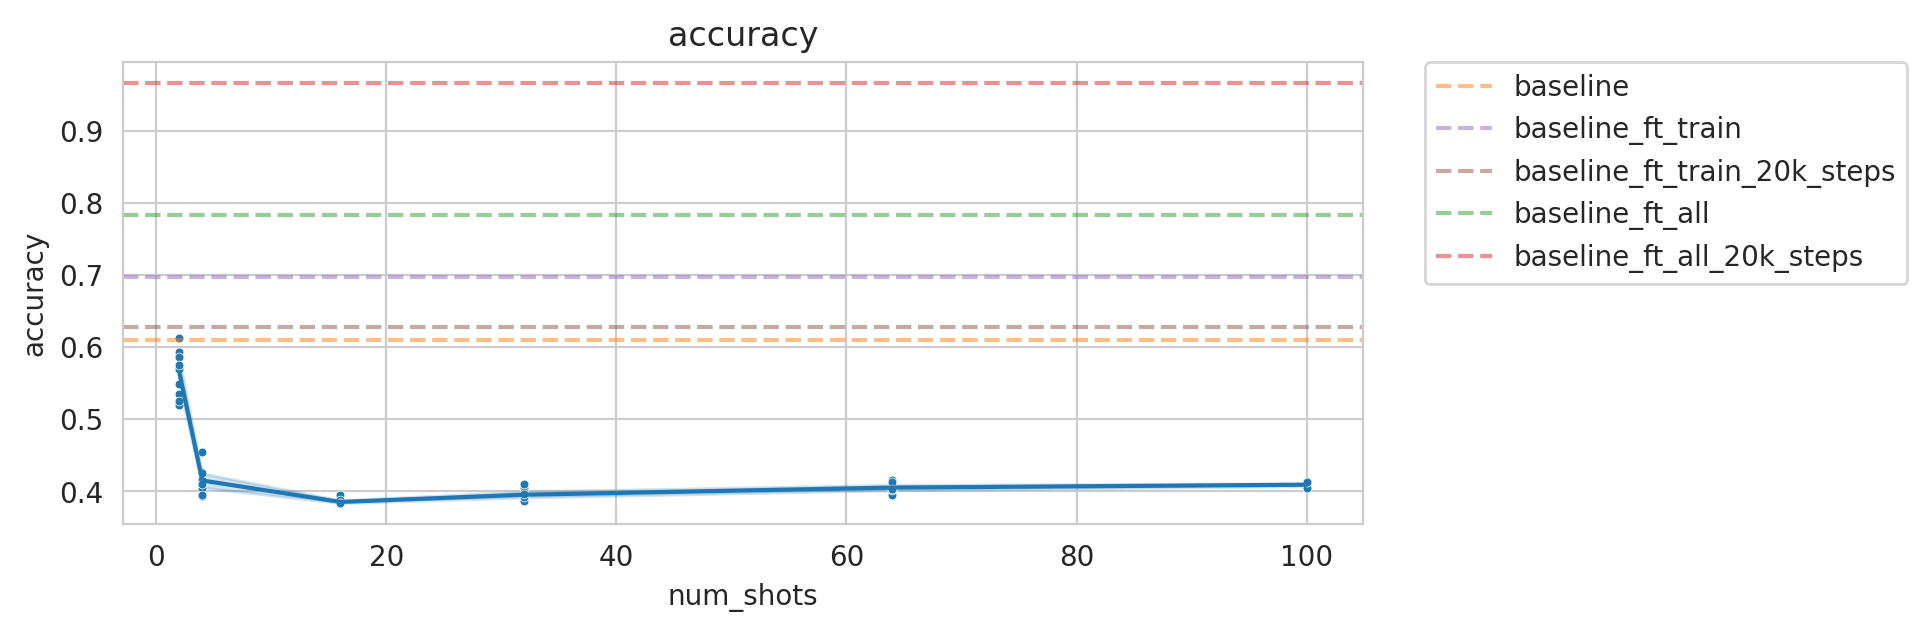

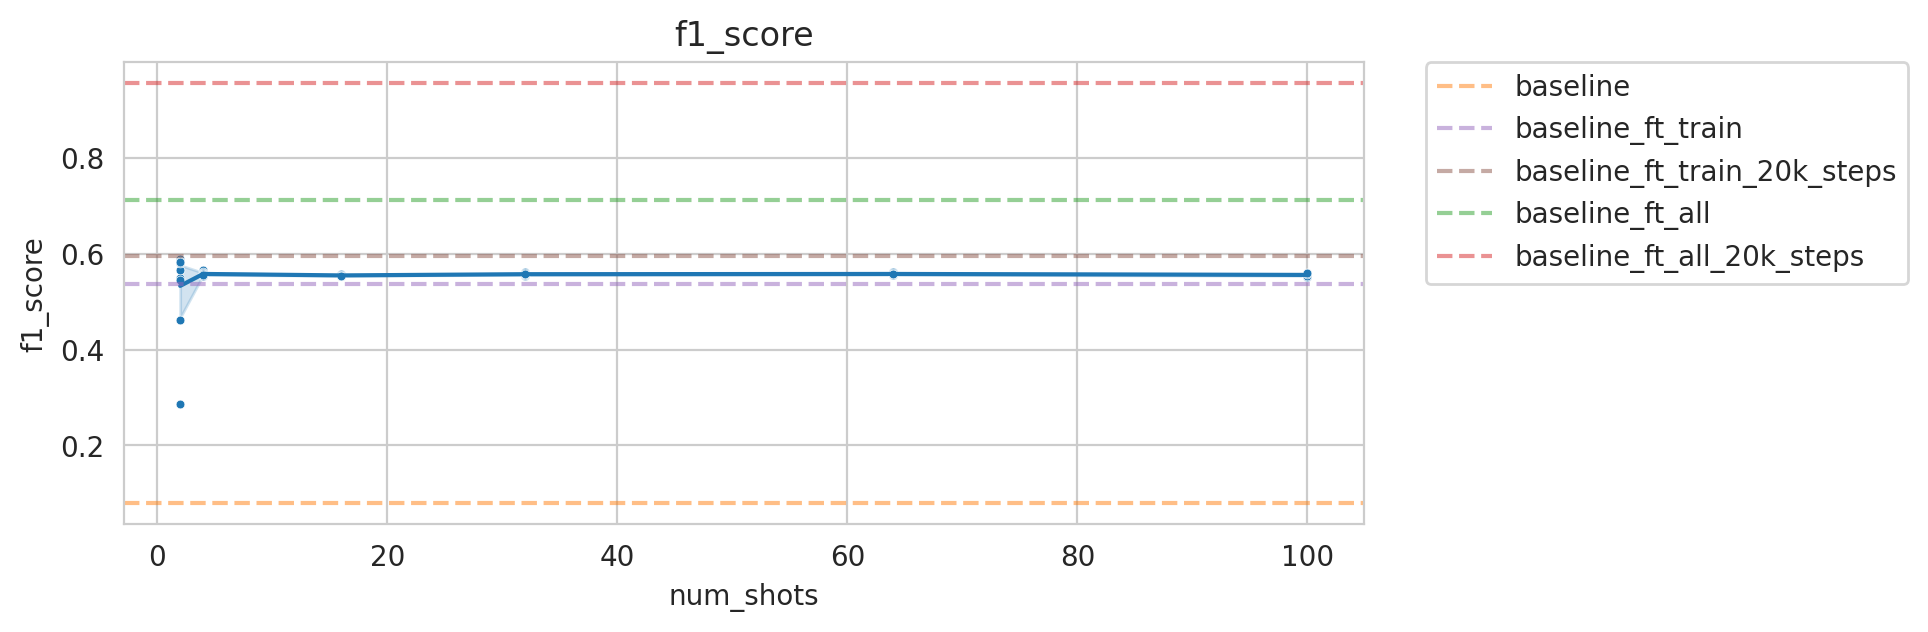

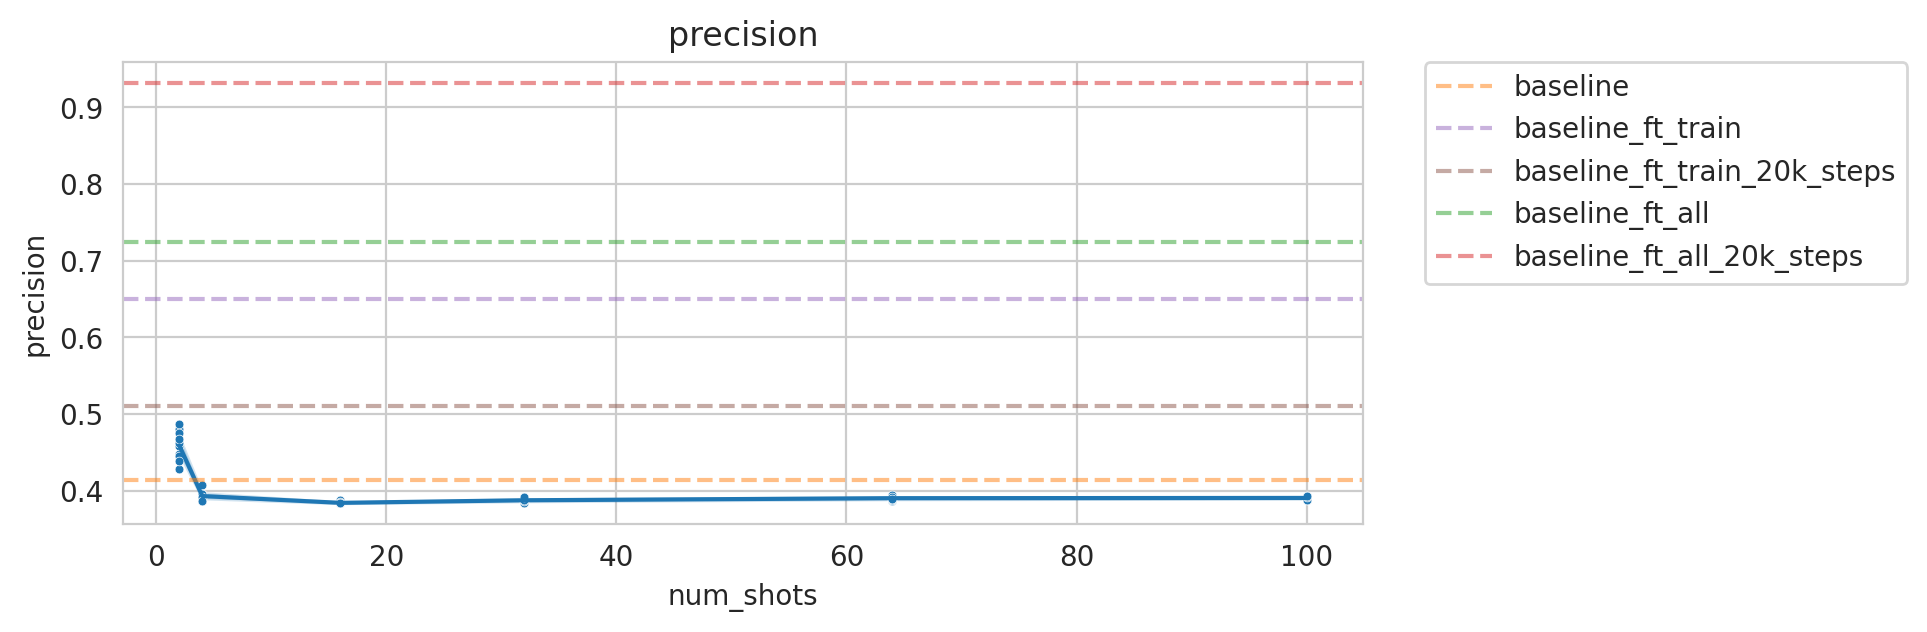

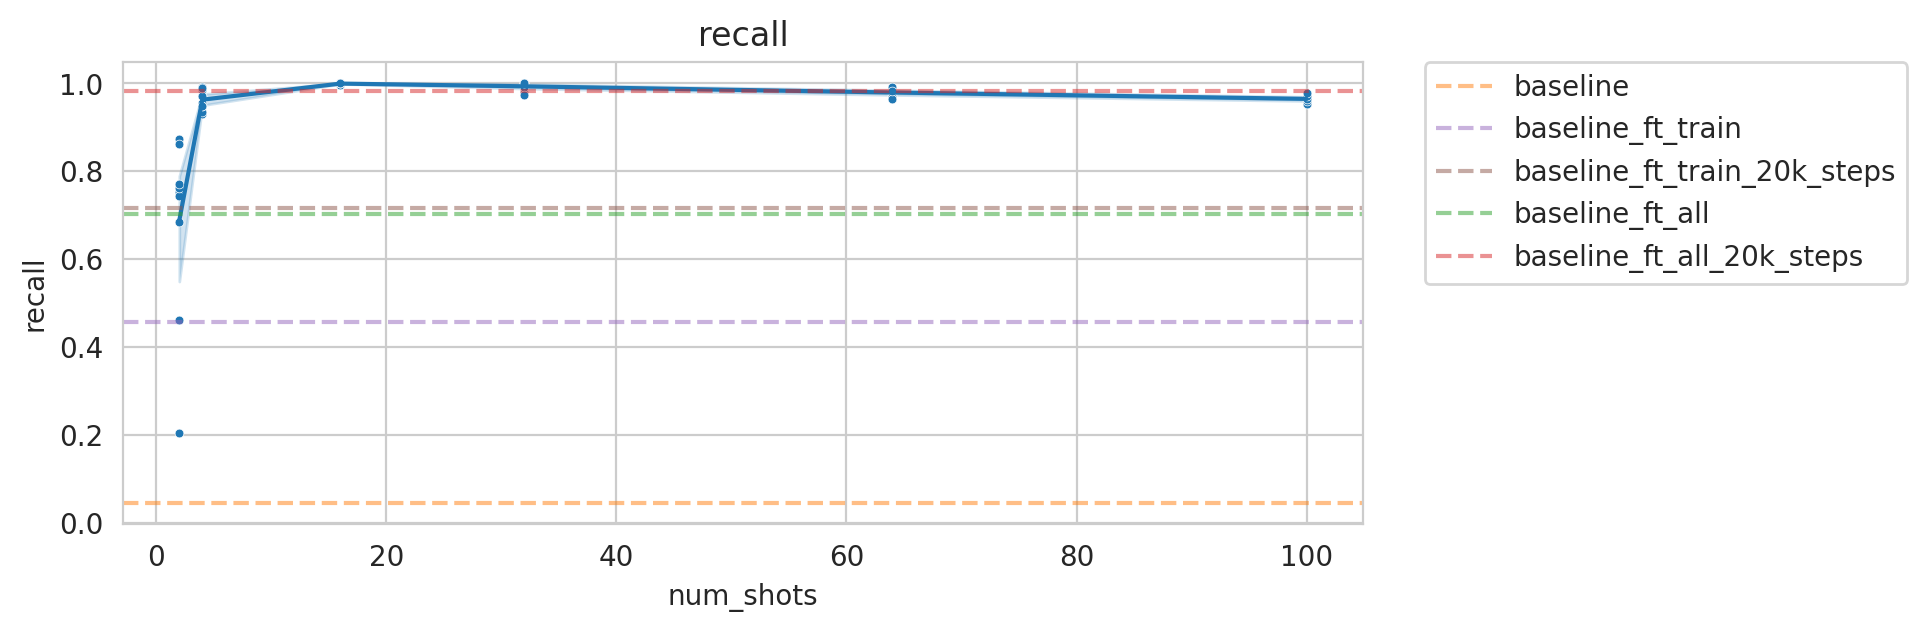

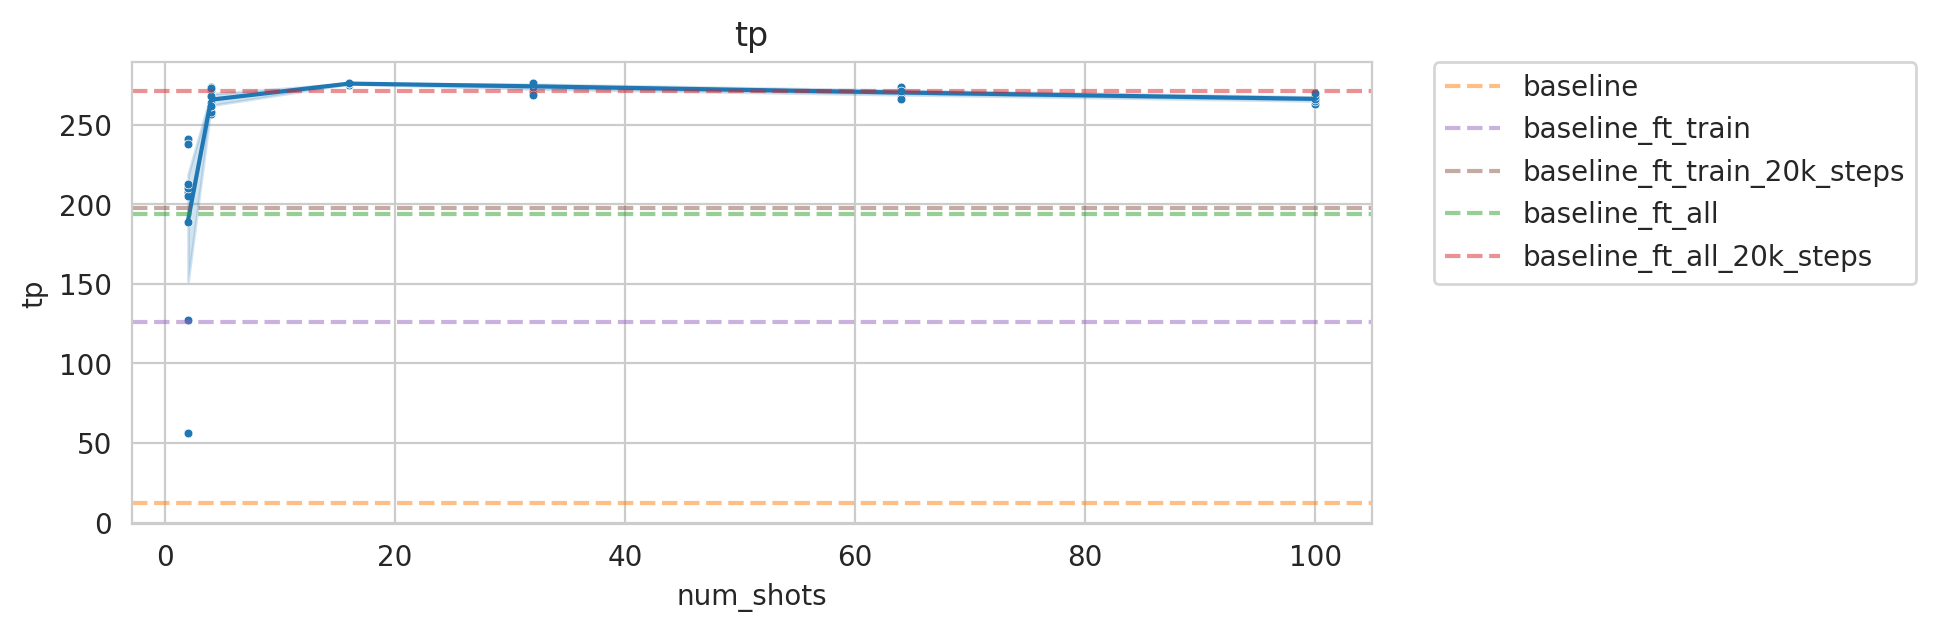

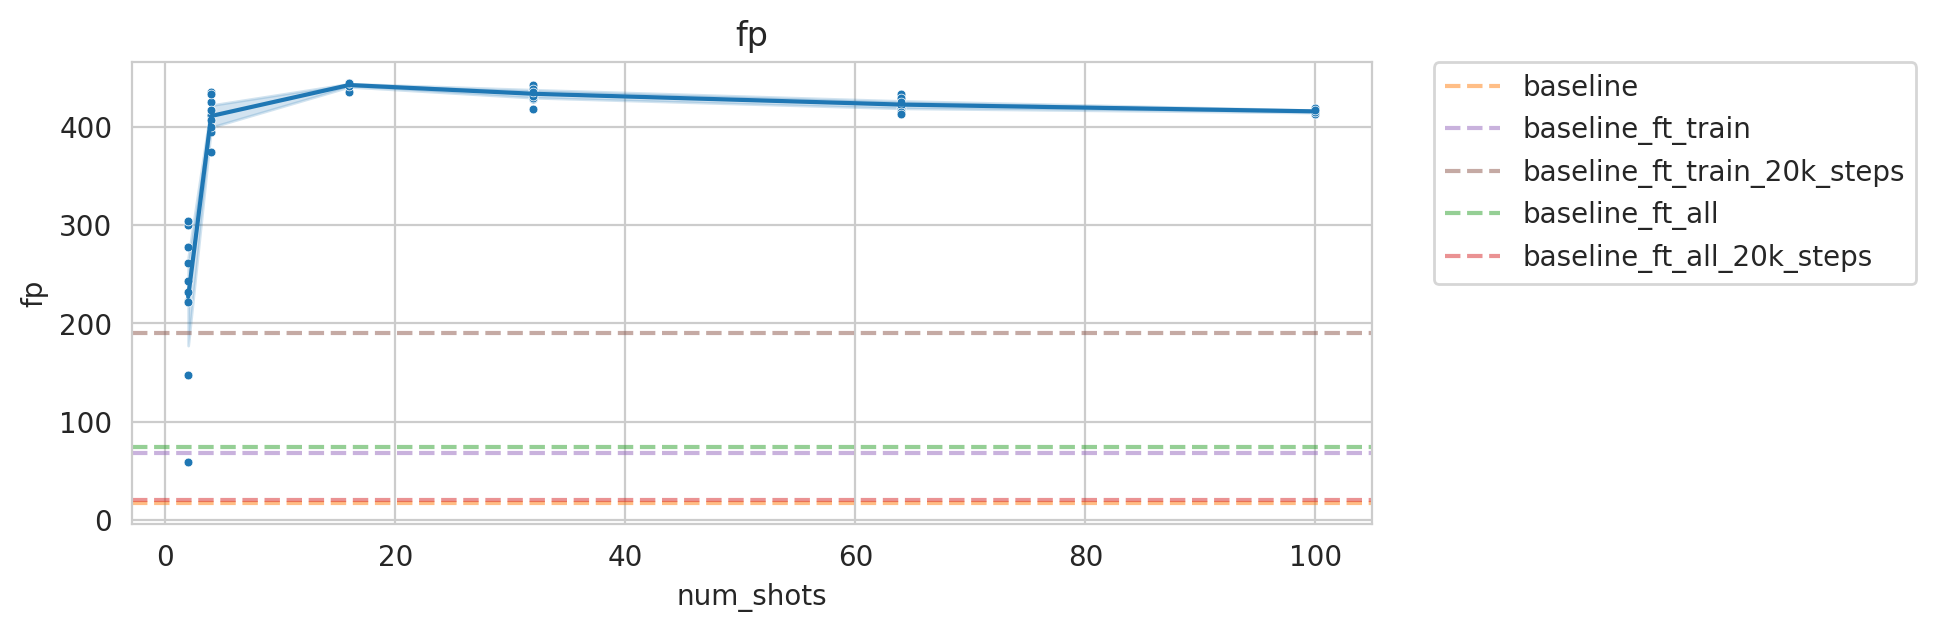

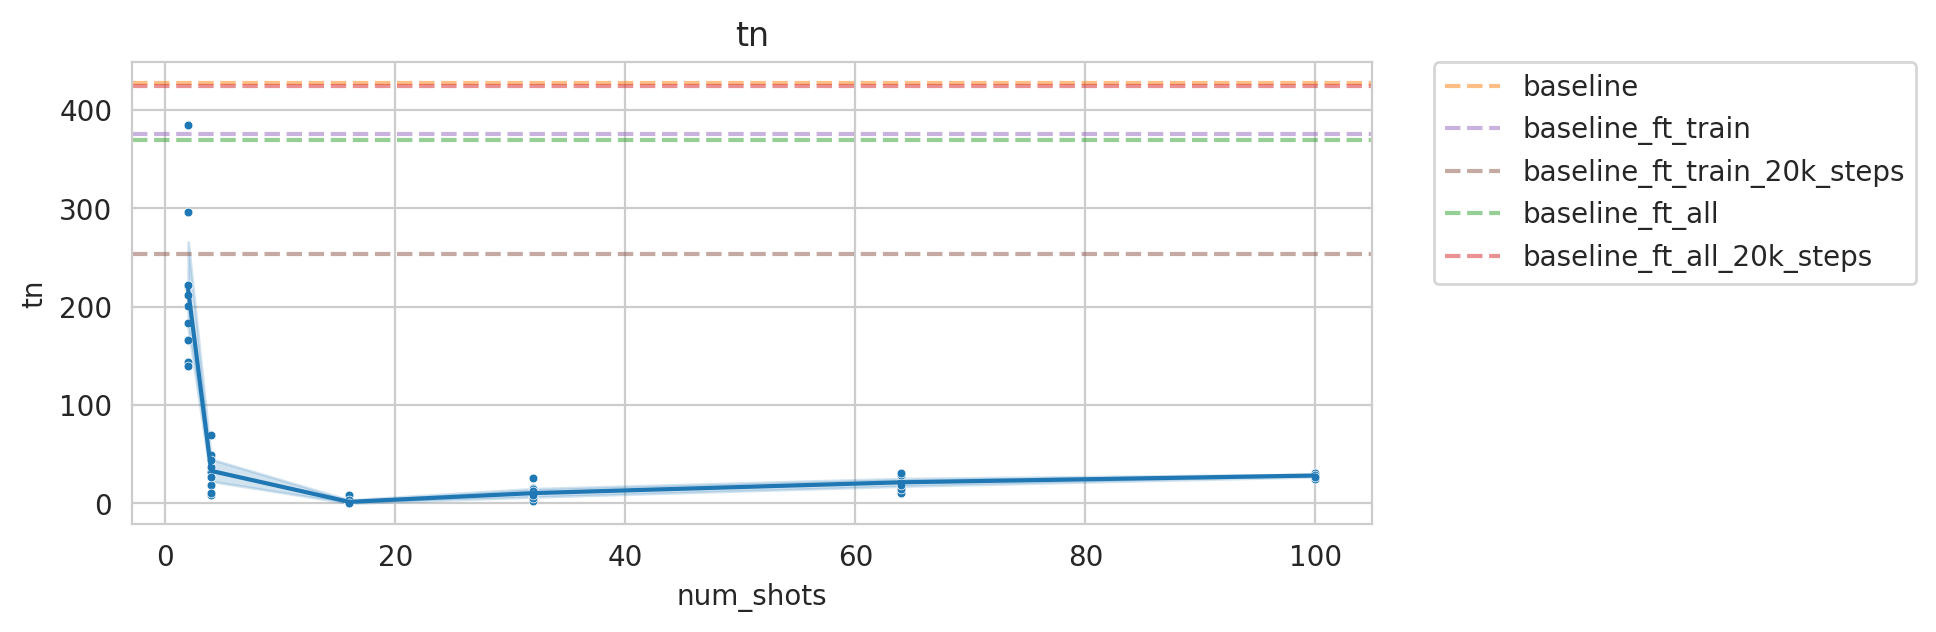

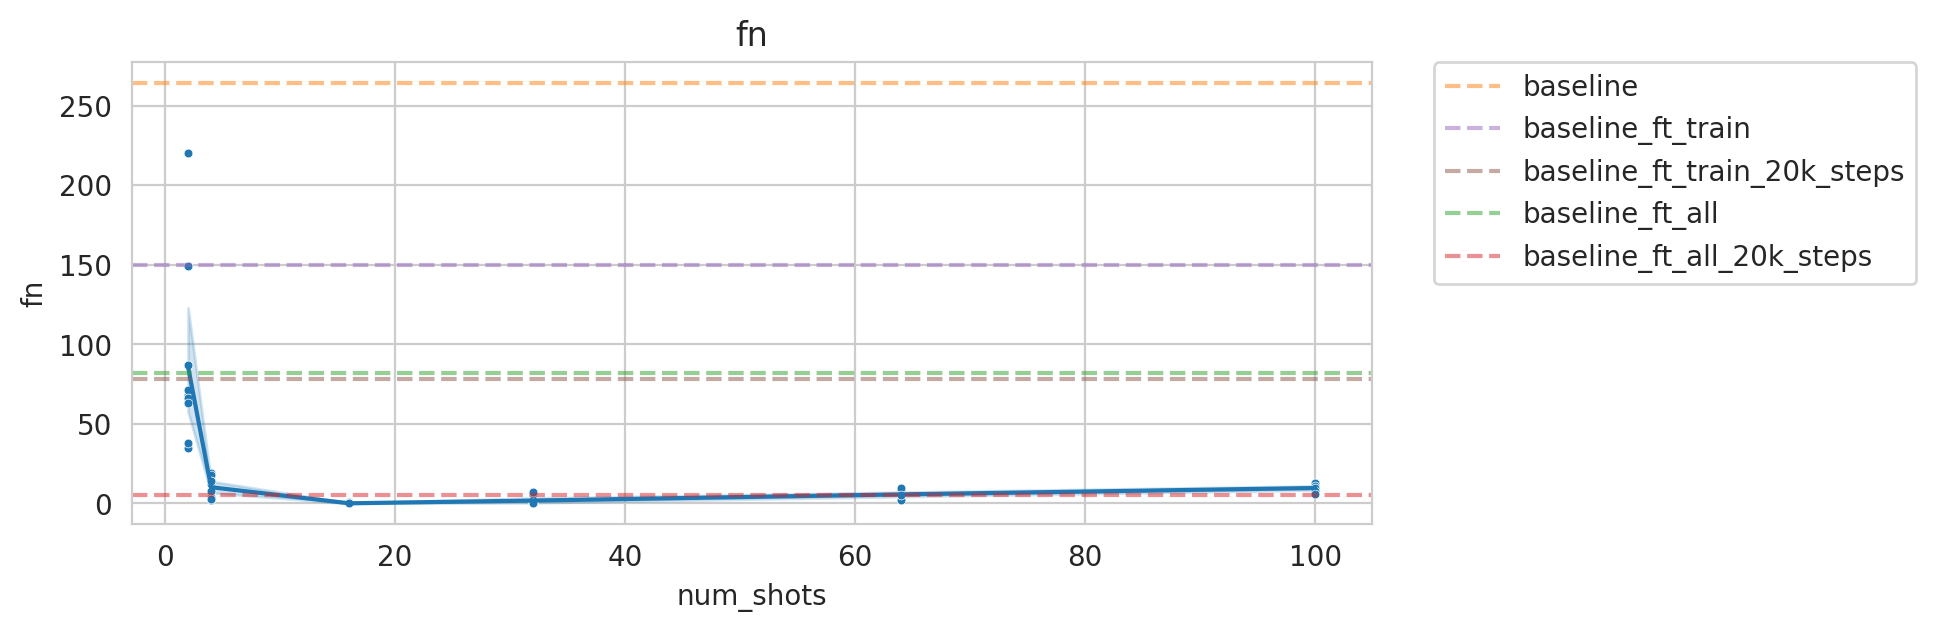

In [43]:
sns.set_style("whitegrid")

T0_BASELINES = sorted(dev_metrics_baselines["index"].unique())
COLOR_MAP = sns.color_palette(n_colors=len(T0_BASELINES)+1)

T0_COLORS = {baseline: COLOR_MAP[i+1] for i, baseline in enumerate(T0_BASELINES)}


for metric in ("accuracy", "f1_score", "precision", "recall", "tp", "fp", "tn", "fn"):
    plt.figure(figsize=(8, 3), dpi=200)
    sns.lineplot(data=dev_metrics_kshot, x="num_shots", y=metric)
    sns.scatterplot(data=dev_metrics_kshot, x="num_shots", y=metric, s=10)
    
    # Plot T0 baselines
    for i, (baseline, value) in dev_metrics_baselines[["index", metric]].iterrows():
        plt.axhline(y=value, label=baseline, color=T0_COLORS[baseline], linestyle='--', alpha=0.5)
        # not owrking: plt.annotate('figure points', xy=(100, 0.5), xycoords='figure points')

    plt.title(metric)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

### Shots

In [60]:
# 
ins_corrs_dev_kshot = pd.read_csv("./results/summ/REALSumm_2class_kshots_dev_inst_corrs.csv")
sys_corrs_dev_kshot = pd.read_csv("./results/summ/REALSumm_2class_kshots_dev_system_corrs.csv")

ins_corrs_dev_kshot["model"] = ins_corrs_dev_kshot["index"].apply(parse_model)
ins_corrs_dev_kshot["num_shots"] = ins_corrs_dev_kshot["index"].apply(parse_shots)
ins_corrs_dev_kshot["seed_shots"] = ins_corrs_dev_kshot["index"].apply(parse_seed)

sys_corrs_dev_kshot["model"] = sys_corrs_dev_kshot["index"].apply(parse_model)
sys_corrs_dev_kshot["num_shots"] = sys_corrs_dev_kshot["index"].apply(parse_shots)
sys_corrs_dev_kshot["seed_shots"] = sys_corrs_dev_kshot["index"].apply(parse_seed)

# 
ins_corrs_dev_baselines = pd.read_csv("./results/summ/REALSumm_2class_t0_baselines_dev_inst_corrs.csv")
sys_corrs_dev_baselines = pd.read_csv("./results/summ/REALSumm_2class_t0_baselines_dev_system_corrs.csv")



ins_metrics_dev = pd.read_csv("./results/summ/REALSumm_2class_dev_instance_corrs.csv")
sys_metrics_dev = pd.read_csv("./results/summ/REALSumm_2class_dev_system_corrs.csv")

In [76]:
ins_metrics_dev.sort_values("kendalltau")

,index,pearsonr,spearmanr,kendalltau
27,bart_score_ref_hypo,-0.074409,-0.054076,-0.040898
7,prism_src_hypo,0.069174,0.074926,0.063020
30,bart_score_cnn_src_hypo,0.082338,0.103455,0.079724
25,bart_score_src_hypo,0.137061,0.126972,0.091720
35,bart_score_para_src_hypo,0.150831,0.149253,0.107353
15,rougel_p,0.136087,0.143591,0.114830
9,rouge1_p,0.153494,0.175441,0.141124
32,bart_score_cnn_ref_hypo,0.232205,0.198766,0.149577
17,bart_score_cnn_ref_hypo_en,0.232308,0.201168,0.150659
0,bert_score_p,0.235147,0.201973,0.152544


In [65]:
ins_metrics_dev.min()

index         bart_score_avg_f
pearsonr             -0.074409
spearmanr            -0.054076
kendalltau           -0.040898
dtype: object

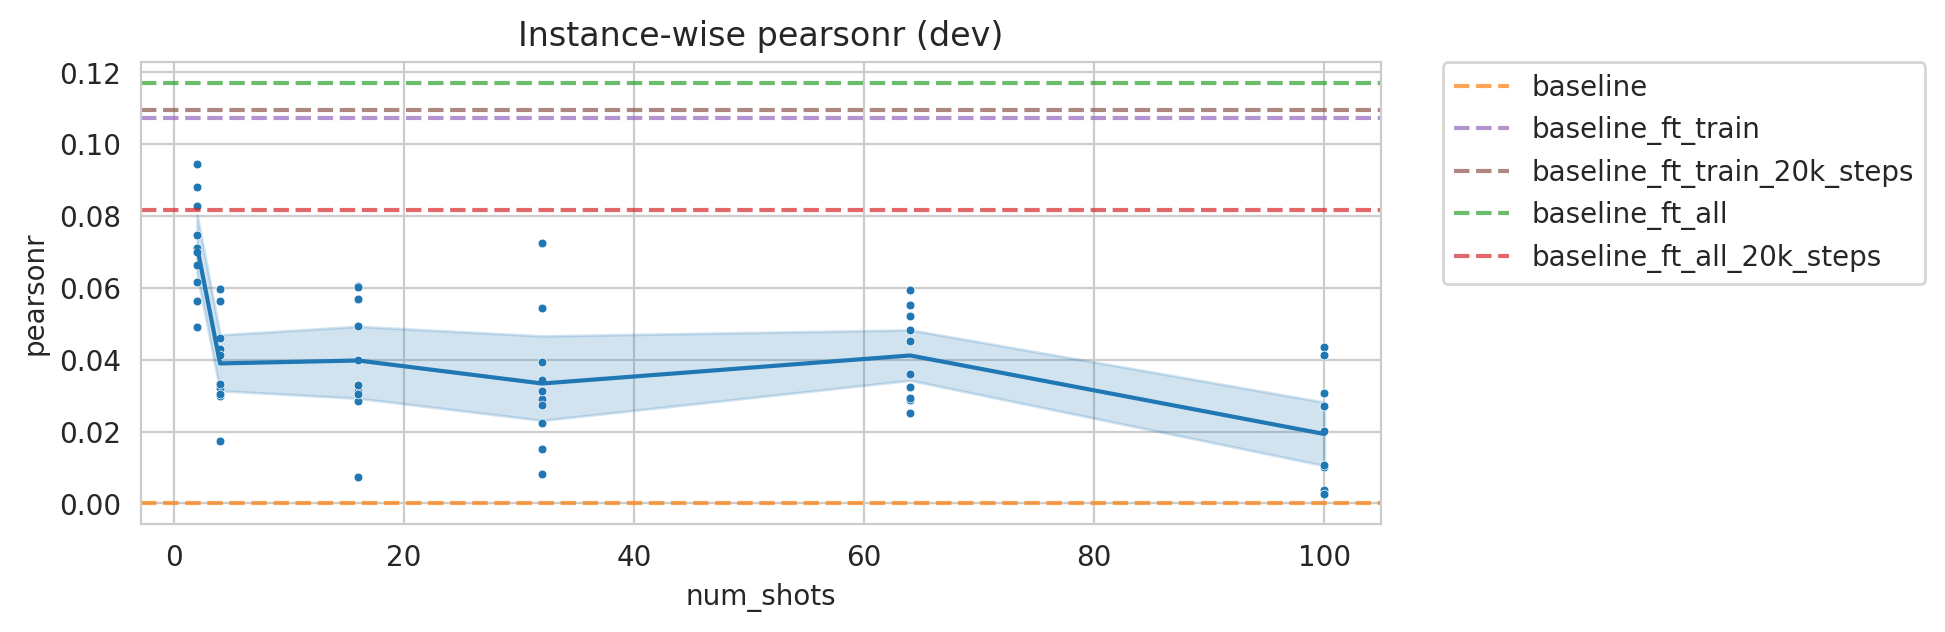

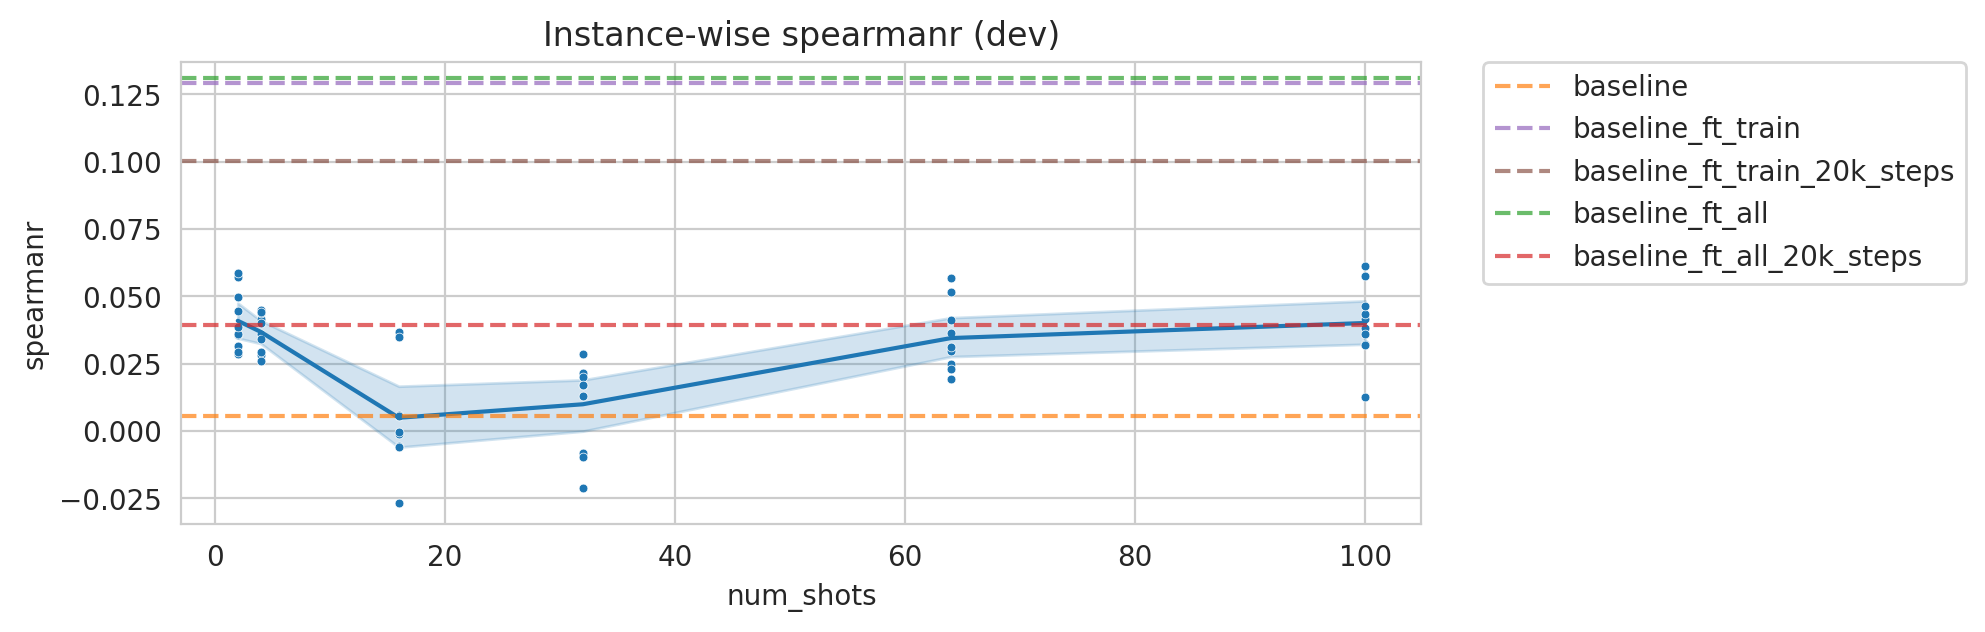

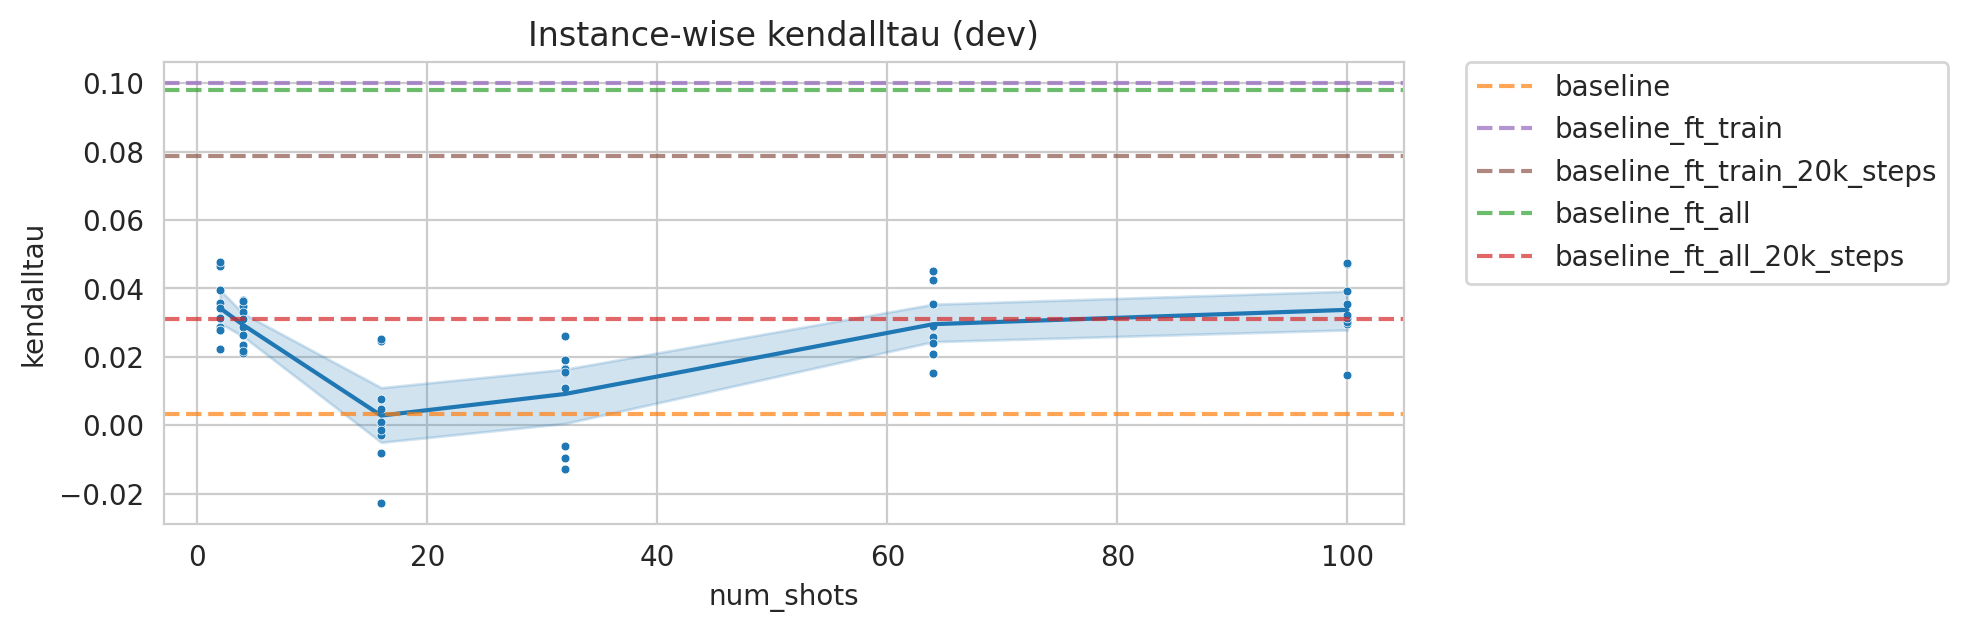

In [58]:
for metric in ("pearsonr", "spearmanr", "kendalltau"):
    plt.figure(figsize=(8, 3), dpi=200)
    sns.lineplot(data=ins_corrs_dev_kshot, x="num_shots", y=metric)
    sns.scatterplot(data=ins_corrs_dev_kshot, x="num_shots", y=metric, s=10)
    
    # Plot T0 baselines
    for i, (baseline, value) in ins_corrs_dev_baselines[["index", metric]].iterrows():
        plt.axhline(y=value, label=baseline, color=T0_COLORS[baseline], linestyle='--', alpha=0.7)
        # not owrking: plt.annotate('figure points', xy=(100, 0.5), xycoords='figure points')

    # Plot metrics (max and lowest)
    
        
    plt.title(f"Instance-wise {metric} (dev)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

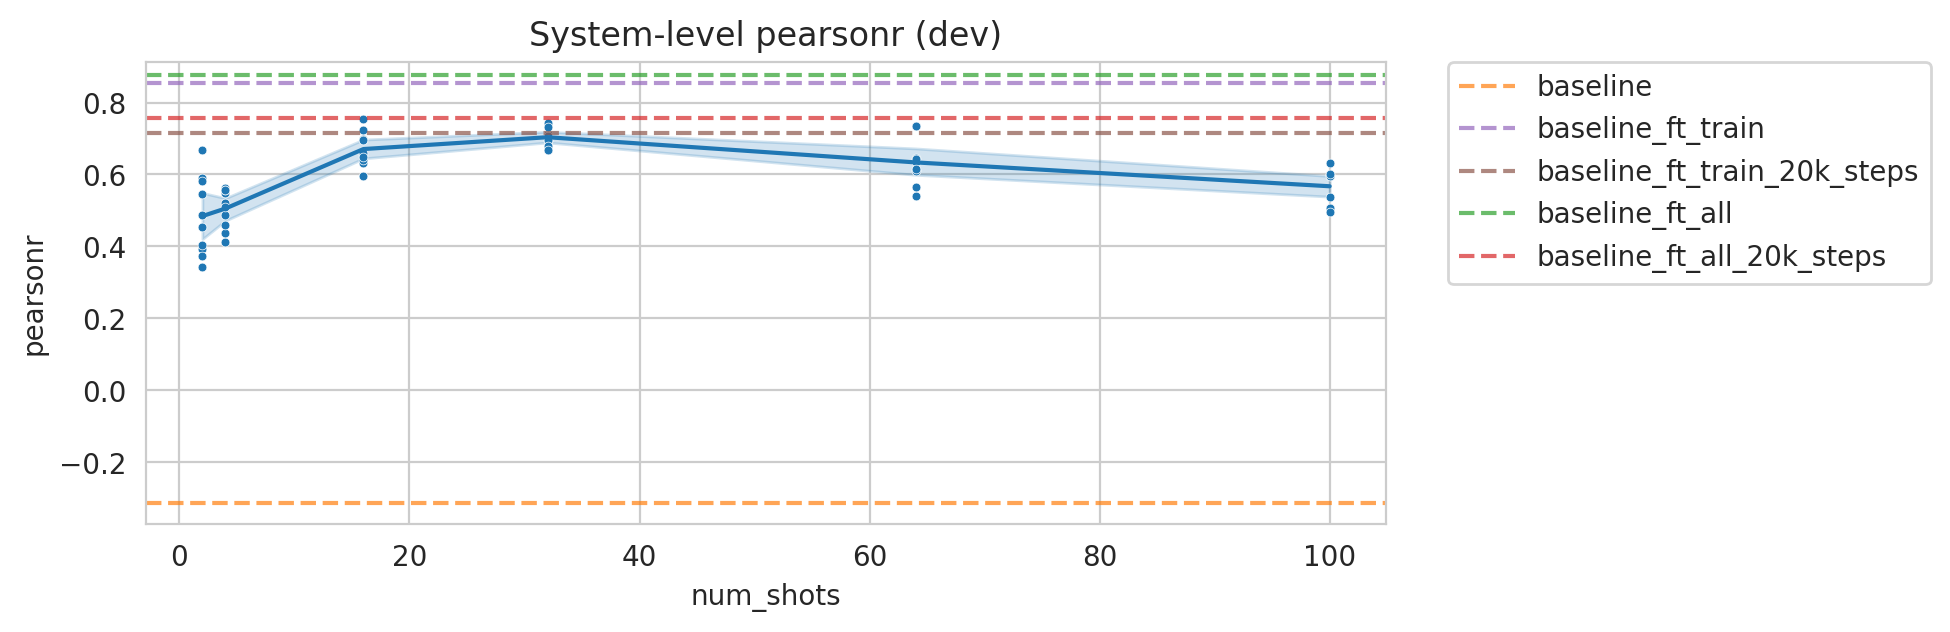

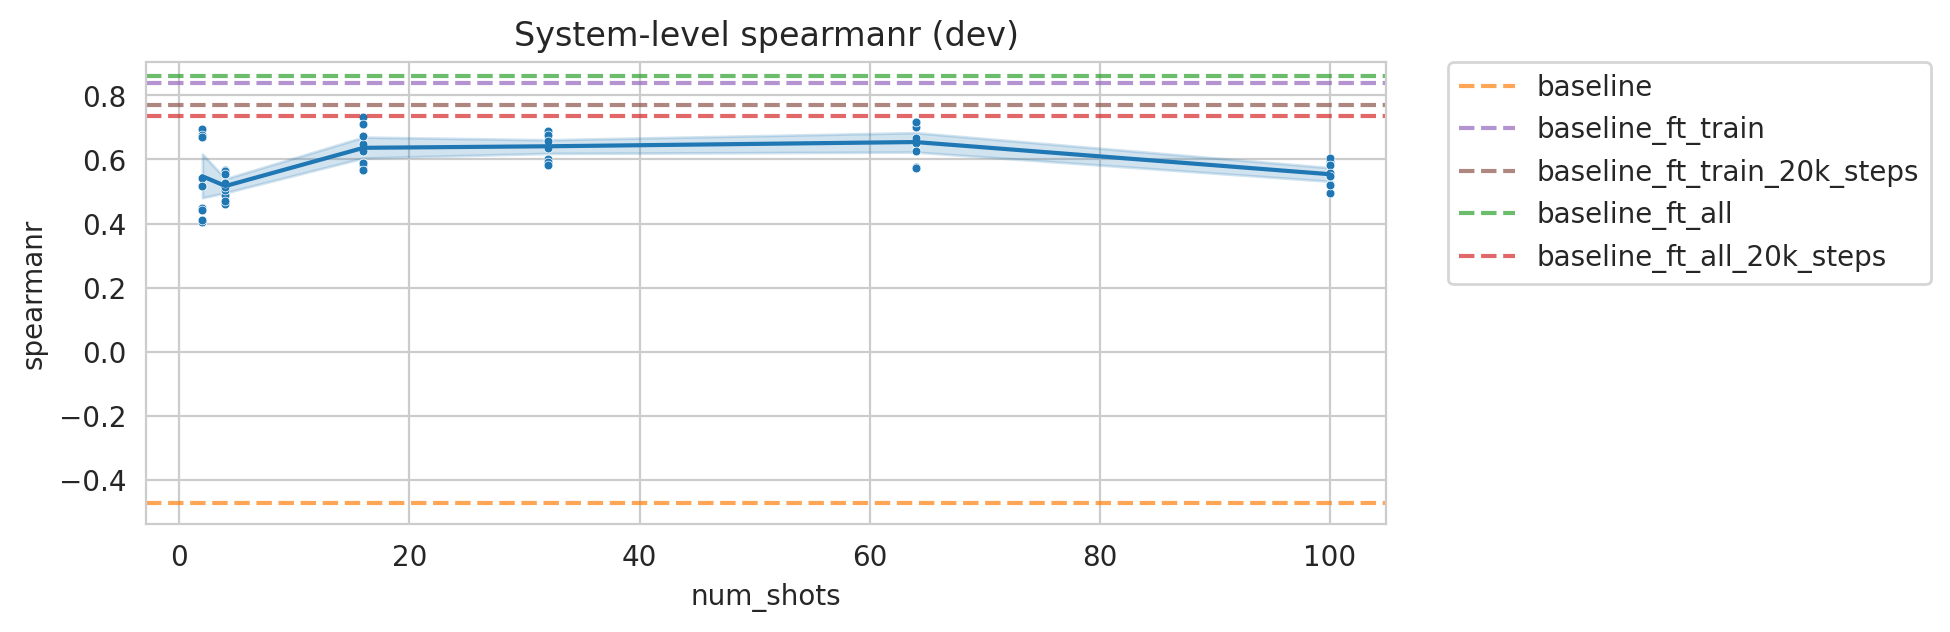

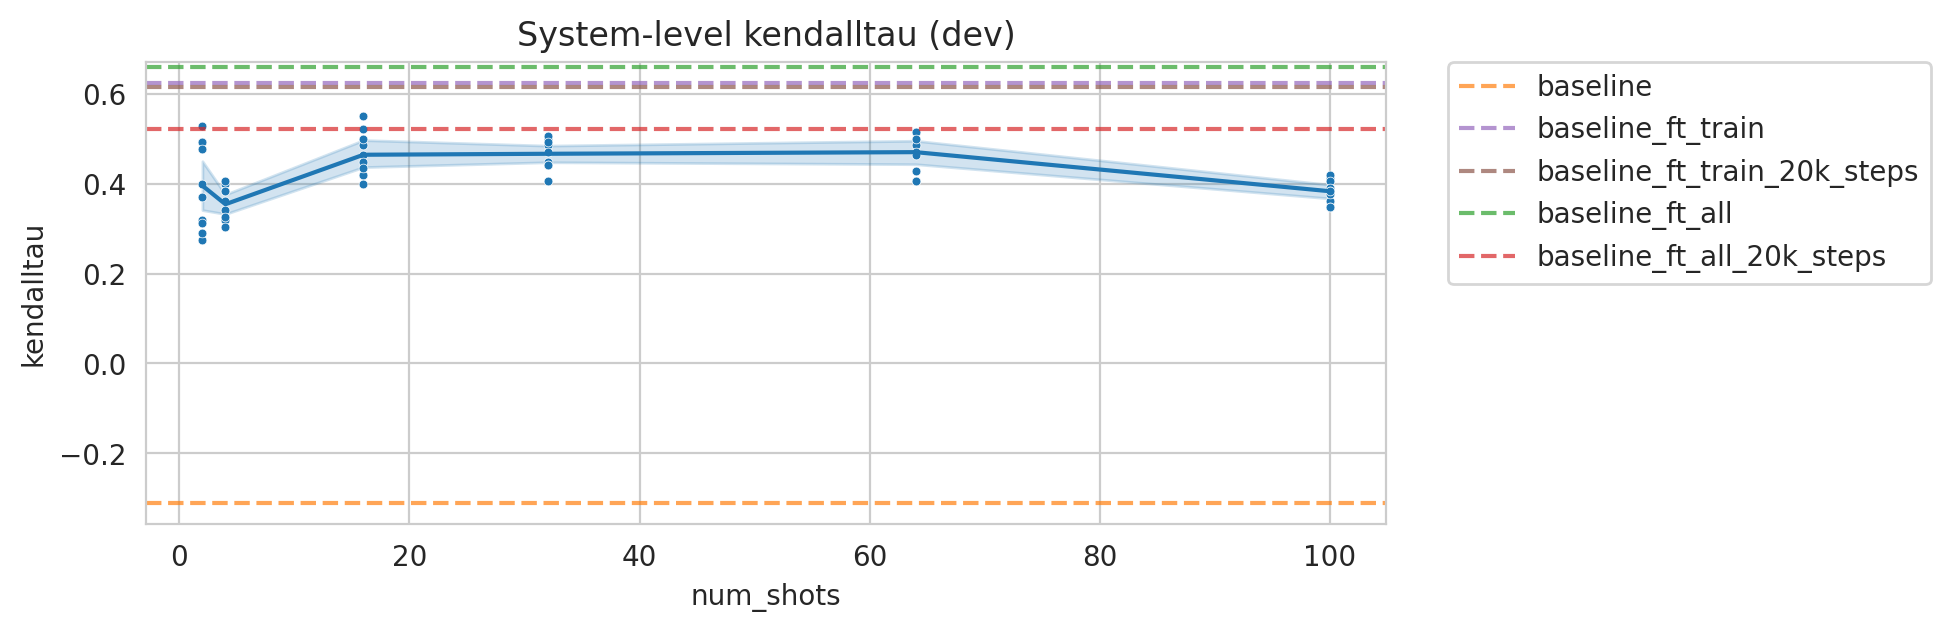

In [59]:
for metric in ("pearsonr", "spearmanr", "kendalltau"):
    plt.figure(figsize=(8, 3), dpi=200)
    sns.lineplot(data=sys_corrs_dev_kshot, x="num_shots", y=metric)
    sns.scatterplot(data=sys_corrs_dev_kshot, x="num_shots", y=metric, s=10)
    
    # Plot T0 baselines
    for i, (baseline, value) in sys_corrs_dev_baselines[["index", metric]].iterrows():
        plt.axhline(y=value, label=baseline, color=T0_COLORS[baseline], linestyle='--', alpha=0.7)
        # not owrking: plt.annotate('figure points', xy=(100, 0.5), xycoords='figure points')

    plt.title(f"System-level {metric} (dev)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

In [127]:
sys_corrs_dev_kshot[sys_corrs_dev_kshot["seed_shots"].isin(["seed284", "seed124"])].sort_values(["seed_shots", "num_shots"])

,level_0,pearsonr,spearmanr,kendalltau,index,model,num_shots,seed_shots
54,log.scores_class_1,0.4035,0.4478,0.3188,t03b_shots2_seed124,t03b,2,seed124
44,log.scores_class_1,0.5220,0.5035,0.3188,t03b_shots4_seed124,t03b,4,seed124
35,log.scores_class_1,0.6313,0.6278,0.4493,t03b_shots16_seed124,t03b,16,seed124
25,log.scores_class_1,0.6968,0.6365,0.4928,t03b_shots32_seed124,t03b,32,seed124
15,log.scores_class_1,0.6132,0.6530,0.4638,t03b_shots64_seed124,t03b,64,seed124
3,log.scores_class_1,0.5970,0.5939,0.4130,t03b_shots100_seed124,t03b,100,seed124
50,log.scores_class_1,0.5907,0.6965,0.5290,t03b_shots2_seed284,t03b,2,seed284
40,log.scores_class_1,0.4882,0.4887,0.3406,t03b_shots4_seed284,t03b,4,seed284
32,log.scores_class_1,0.7532,0.7313,0.5507,t03b_shots16_seed284,t03b,16,seed284
24,log.scores_class_1,0.7430,0.6757,0.5072,t03b_shots32_seed284,t03b,32,seed284


In [129]:
ins_corrs_dev_kshot[ins_corrs_dev_kshot["seed_shots"].isin(["seed284", "seed124"])].sort_values(["seed_shots", "num_shots"])

,level_0,pearsonr,spearmanr,kendalltau,index,model,num_shots,seed_shots
54,log.scores_class_1,0.069922,0.044481,0.035750,t03b_shots2_seed124,t03b,2,seed124
44,log.scores_class_1,0.029805,0.025853,0.021115,t03b_shots4_seed124,t03b,4,seed124
35,log.scores_class_1,0.031321,0.005624,0.000993,t03b_shots16_seed124,t03b,16,seed124
25,log.scores_class_1,0.008241,-0.020950,-0.012767,t03b_shots32_seed124,t03b,32,seed124
15,log.scores_class_1,0.028753,0.036474,0.028570,t03b_shots64_seed124,t03b,64,seed124
3,log.scores_class_1,0.003628,0.041530,0.035339,t03b_shots100_seed124,t03b,100,seed124
50,log.scores_class_1,0.071145,0.035529,0.028718,t03b_shots2_seed284,t03b,2,seed284
40,log.scores_class_1,0.043056,0.028089,0.023505,t03b_shots4_seed284,t03b,4,seed284
32,log.scores_class_1,0.060428,0.036612,0.024689,t03b_shots16_seed284,t03b,16,seed284
24,log.scores_class_1,0.029190,0.020093,0.016409,t03b_shots32_seed284,t03b,32,seed284


In [88]:
realsumm_train = pd.read_csv("./experiments/summ_data/REALSumm/2class_train.csv")
train_base_rate = (realsumm_train["label"] == 1).sum() / len(realsumm_train)

realsumm_dev = pd.read_csv("./experiments/summ_data/REALSumm/2class_dev.csv")
dev_base_rate = (realsumm_dev["label"] == 1).sum() / len(realsumm_dev)

realsumm_test = pd.read_csv("./experiments/summ_data/REALSumm/2class_test.csv")
test_base_rate = (realsumm_test["label"] == 1).sum() / len(realsumm_test)

realsumm_all = pd.read_csv("./experiments/summ_data/REALSumm/2class_all.csv")
all_base_rate = (realsumm_all["label"] == 1).sum() / len(realsumm_all)

[all_base_rate, train_base_rate, dev_base_rate, test_base_rate]

[0.36791666666666667,
 0.3729166666666667,
 0.38333333333333336,
 0.3458333333333333]

<AxesSubplot:>

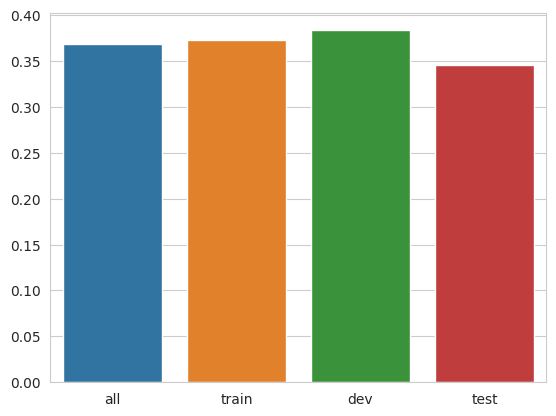

In [87]:
sns.barplot(x=["all", "train", "dev", "test"],
           y=[all_base_rate, train_base_rate, dev_base_rate, test_base_rate])

<AxesSubplot:xlabel='sys_score_litepyramid_recall', ylabel='Count'>

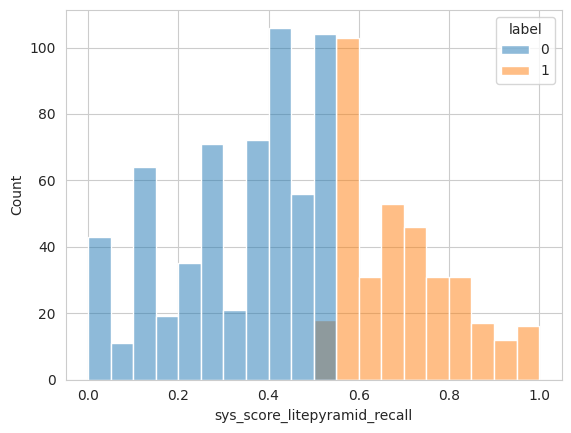

In [96]:
hist_kwargs = {"bins": 20, "binrange": (0,1), "hue": "label"}
sns.histplot(data=realsumm_train, x="sys_score_litepyramid_recall", **hist_kwargs)

<AxesSubplot:xlabel='sys_score_litepyramid_recall', ylabel='Count'>

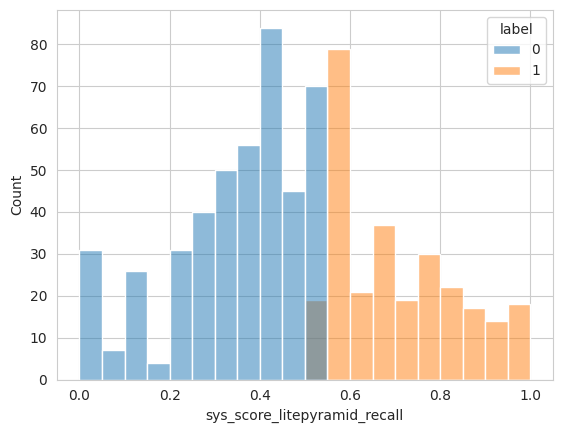

In [97]:
sns.histplot(data=realsumm_dev, x="sys_score_litepyramid_recall", **hist_kwargs)

<AxesSubplot:xlabel='sys_score_litepyramid_recall', ylabel='Count'>

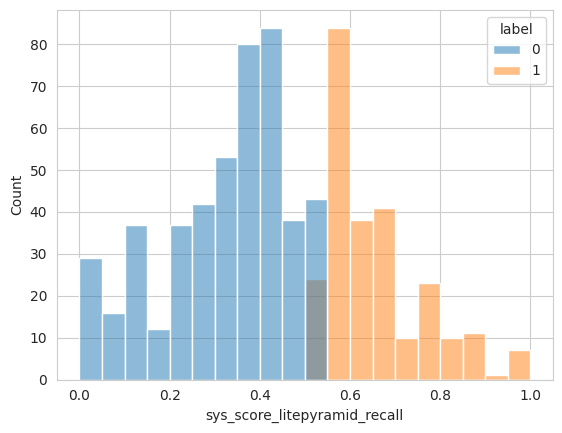

In [98]:
sns.histplot(data=realsumm_test, x="sys_score_litepyramid_recall", **hist_kwargs)

<AxesSubplot:xlabel='sys_score_litepyramid_recall', ylabel='Count'>

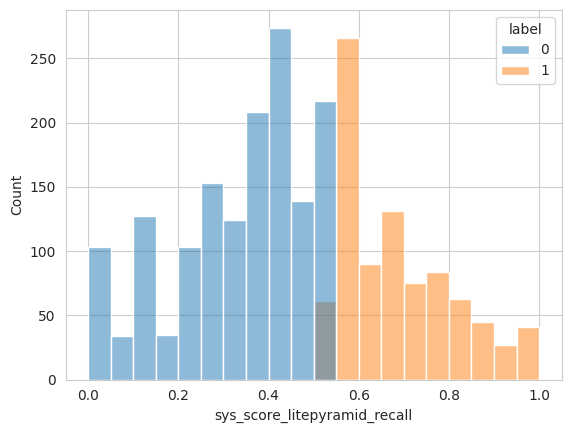

In [100]:
sns.histplot(data=realsumm_all, x="sys_score_litepyramid_recall", **hist_kwargs)

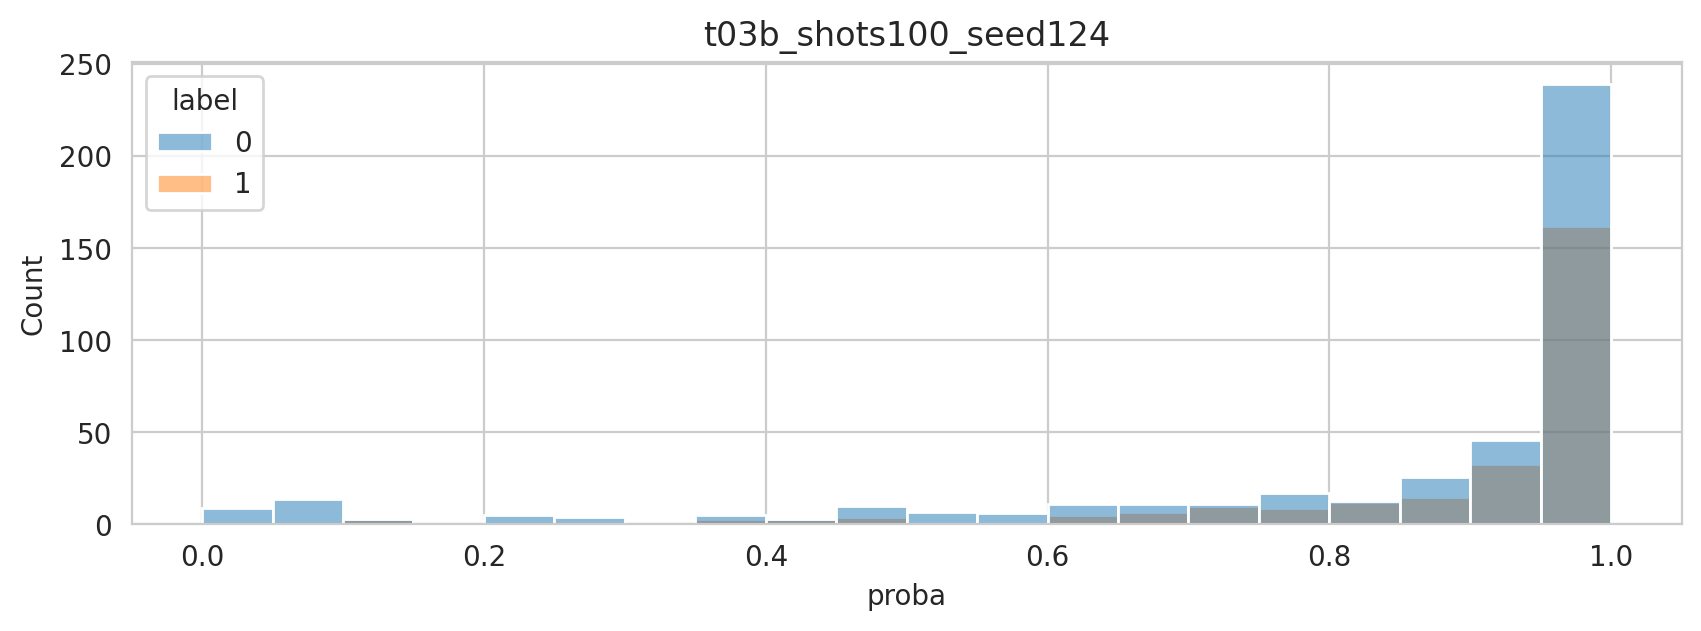

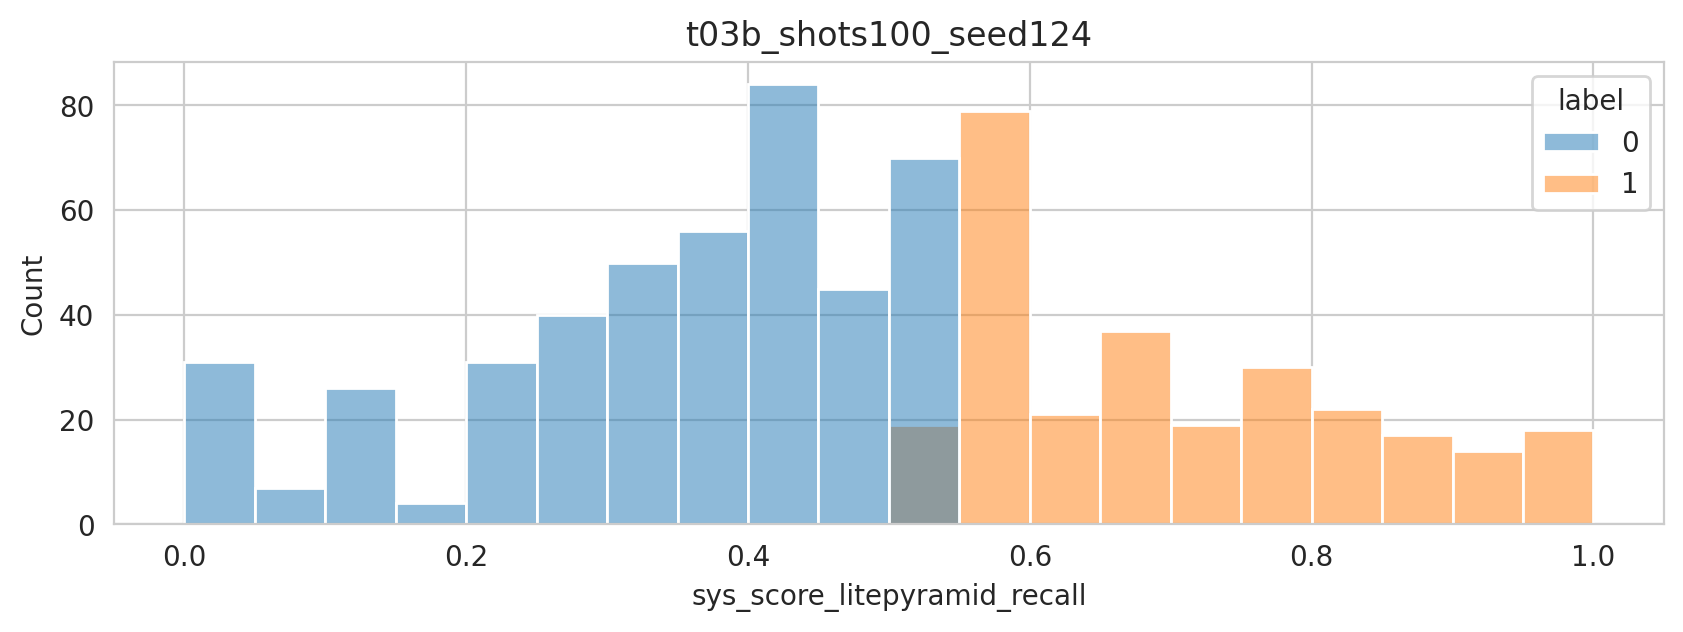

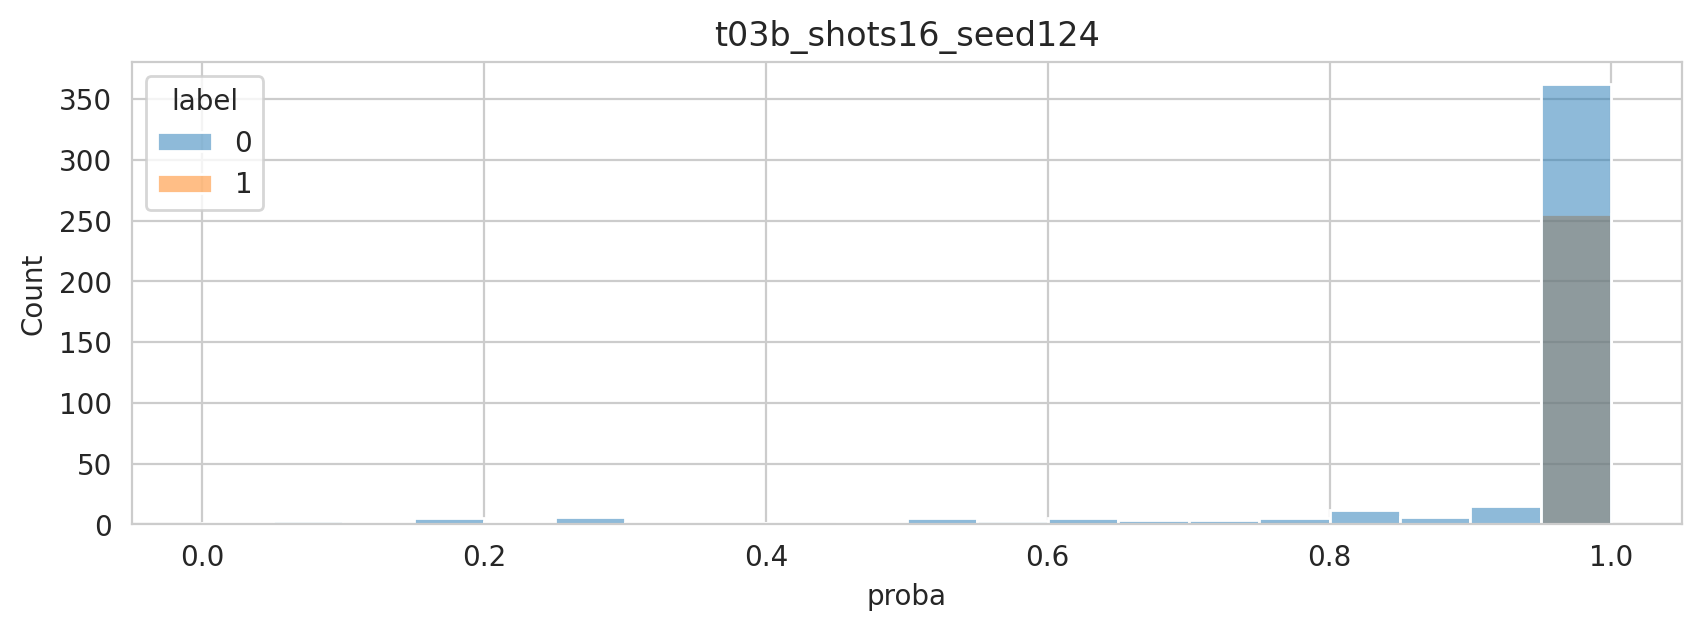

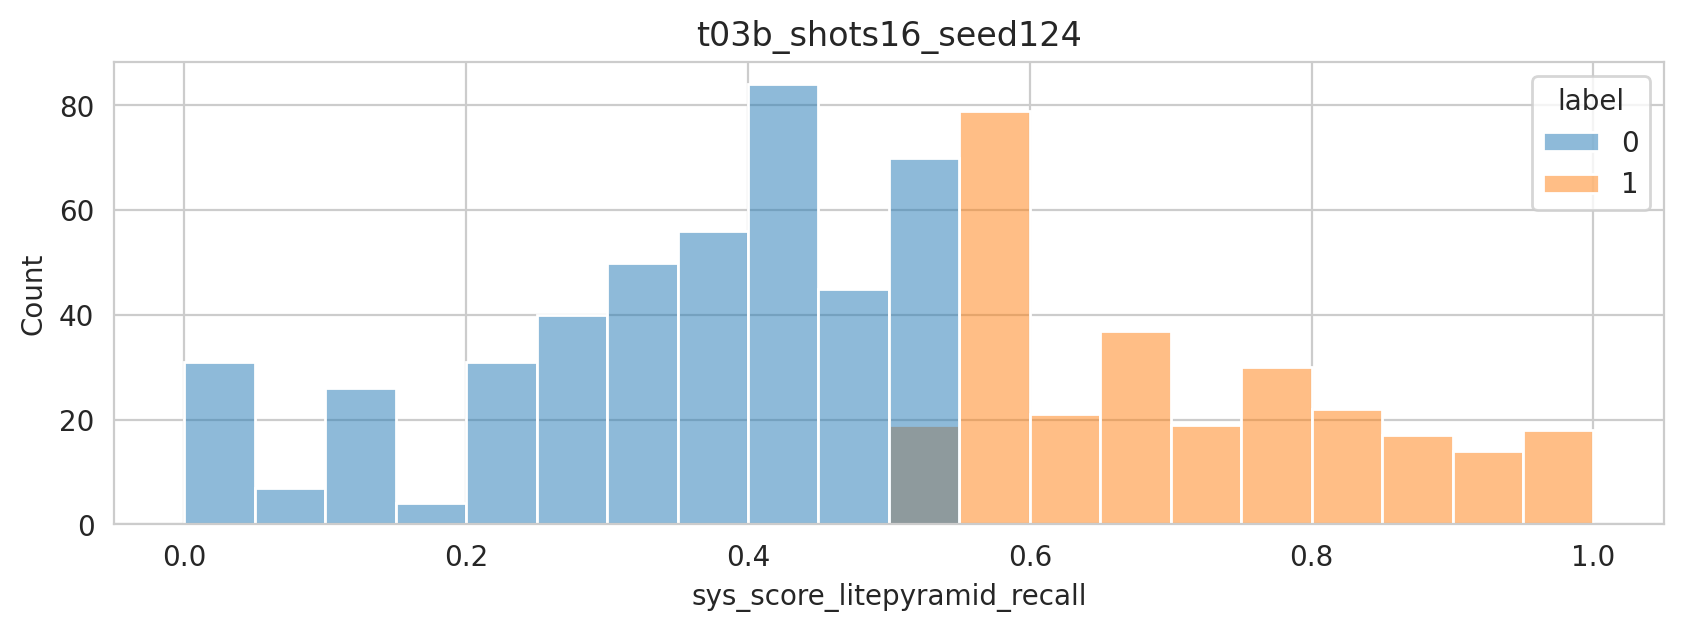

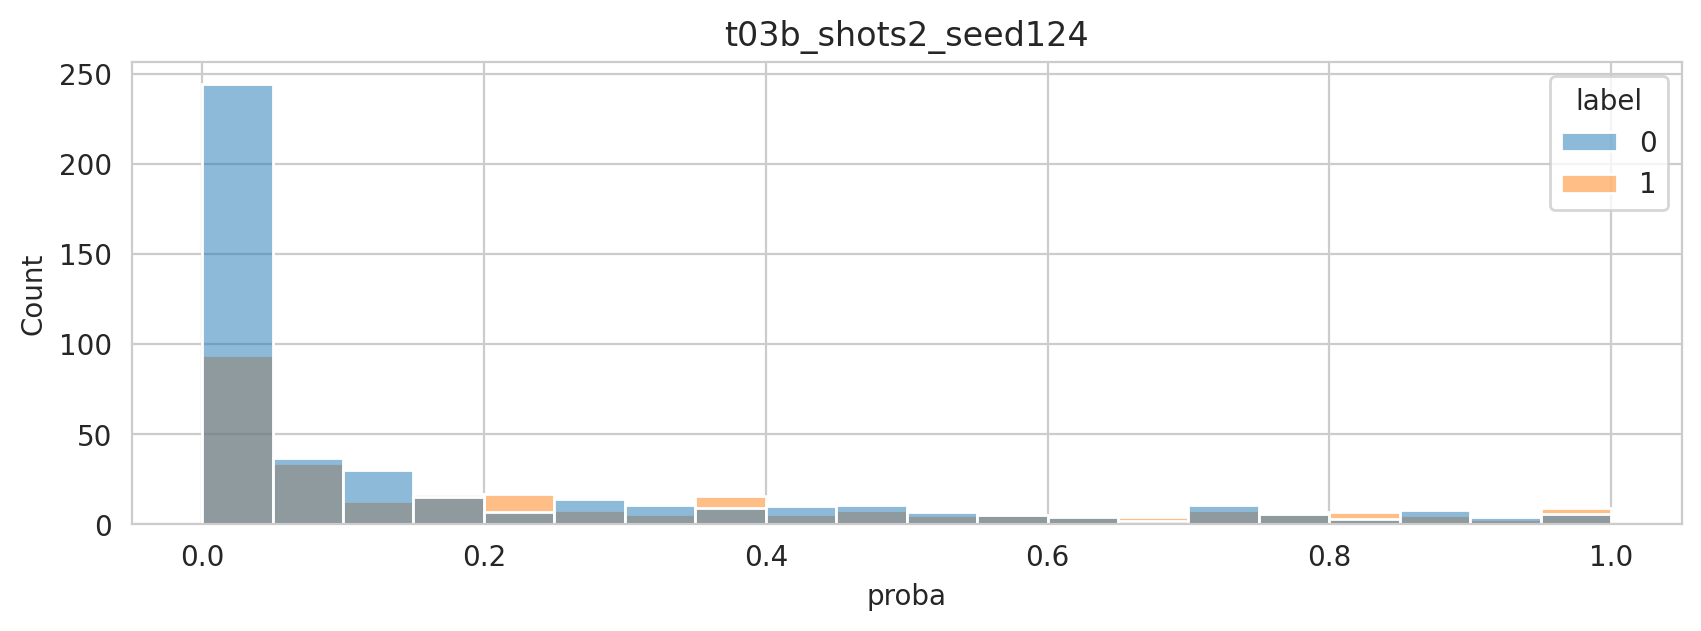

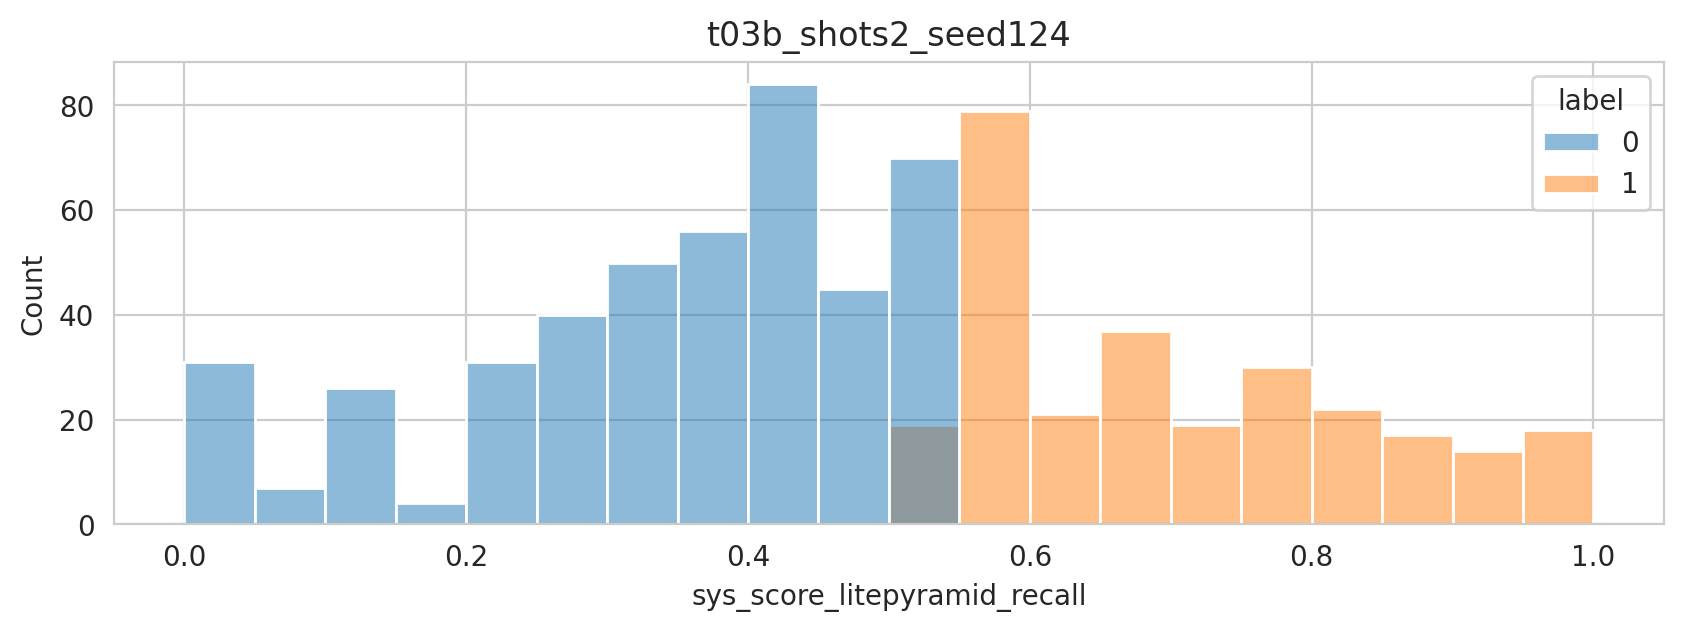

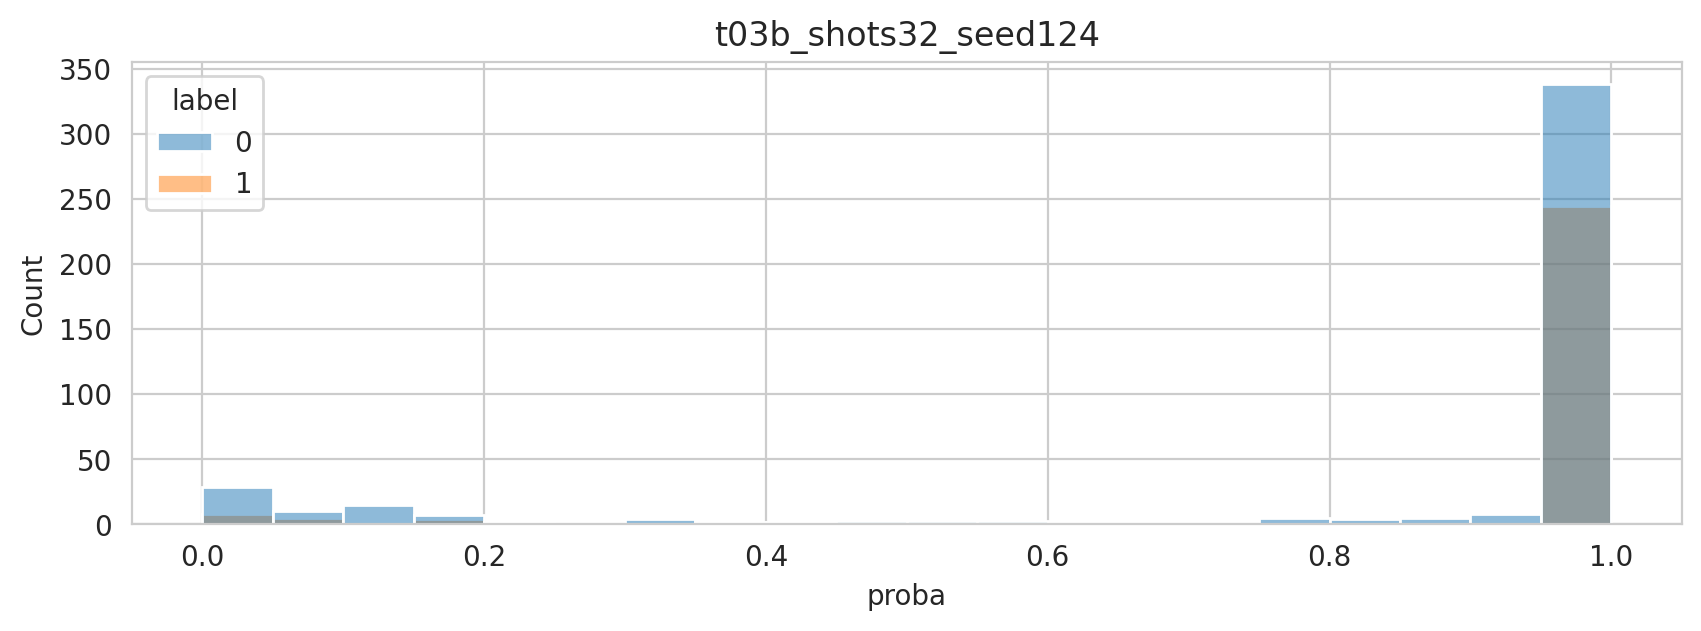

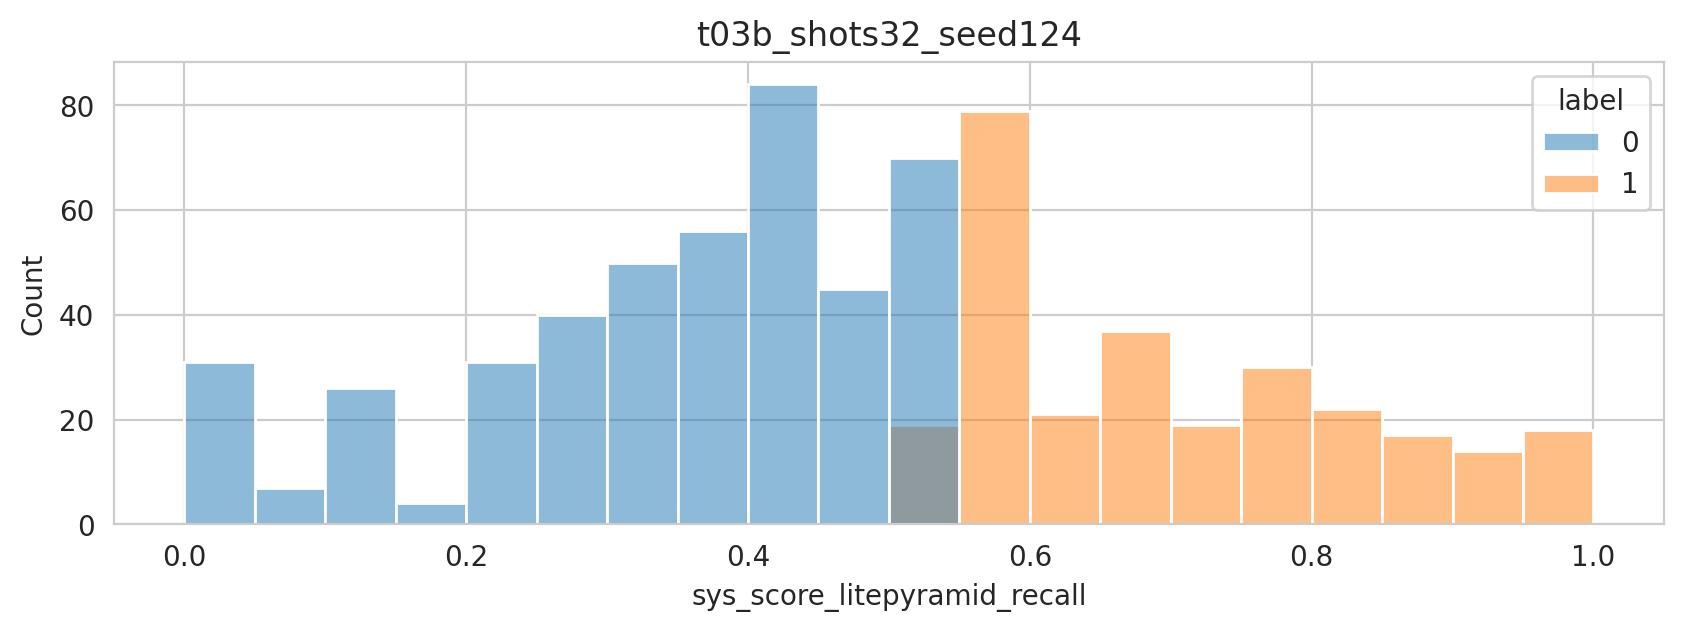

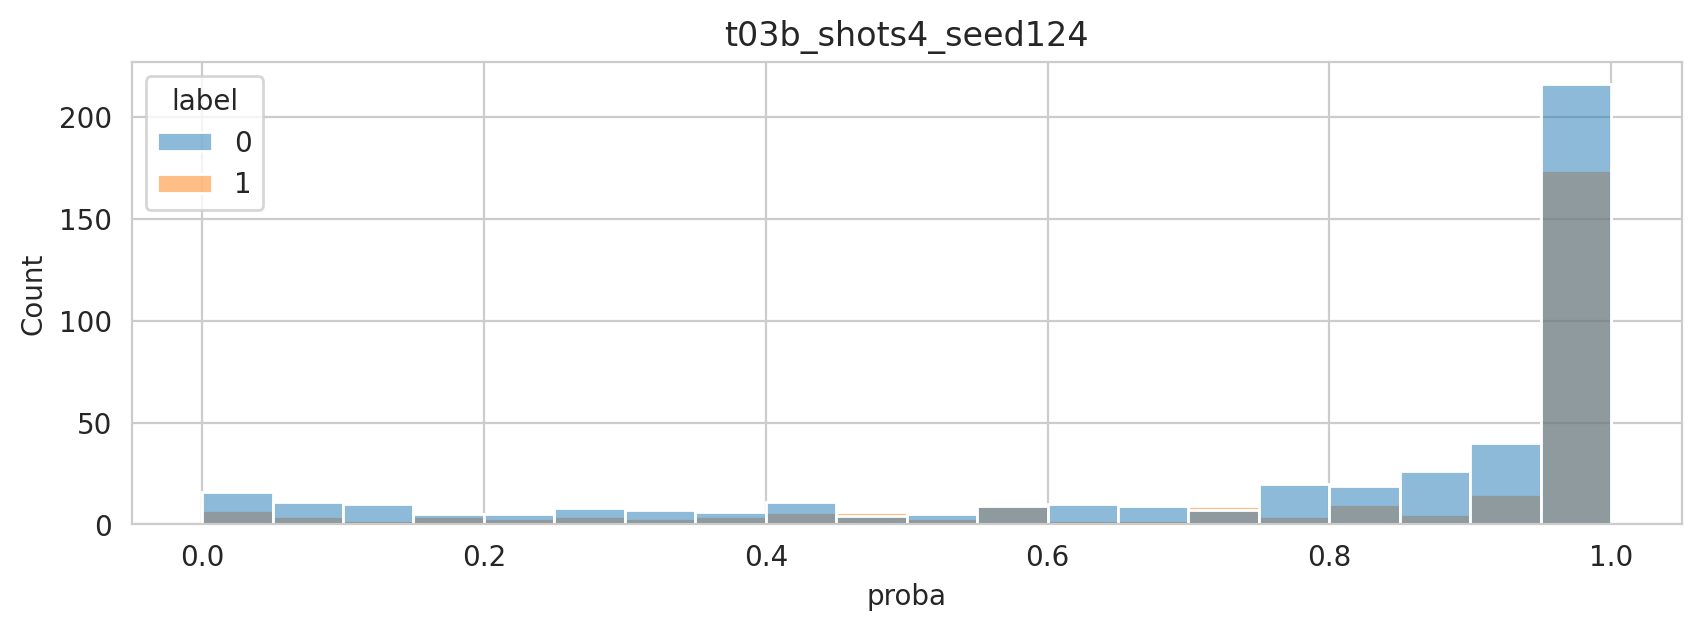

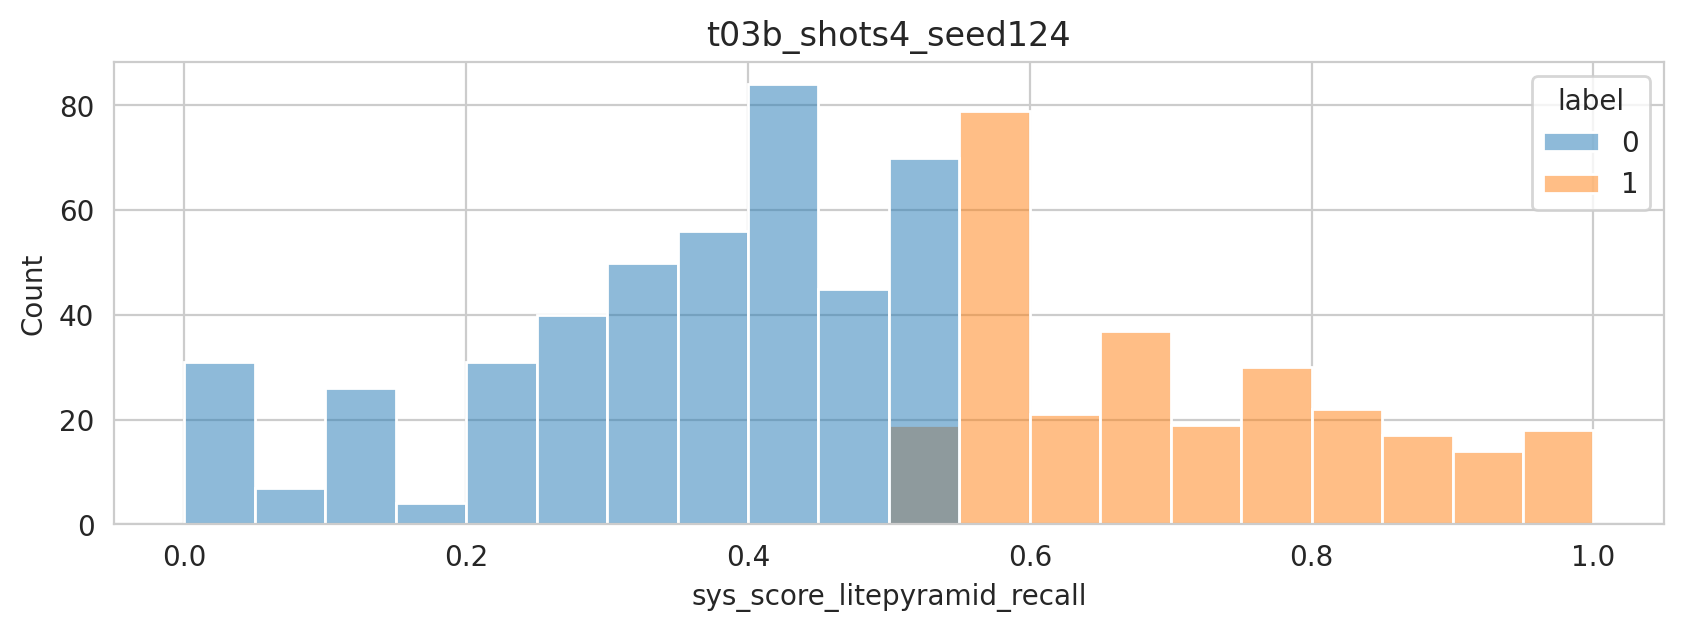

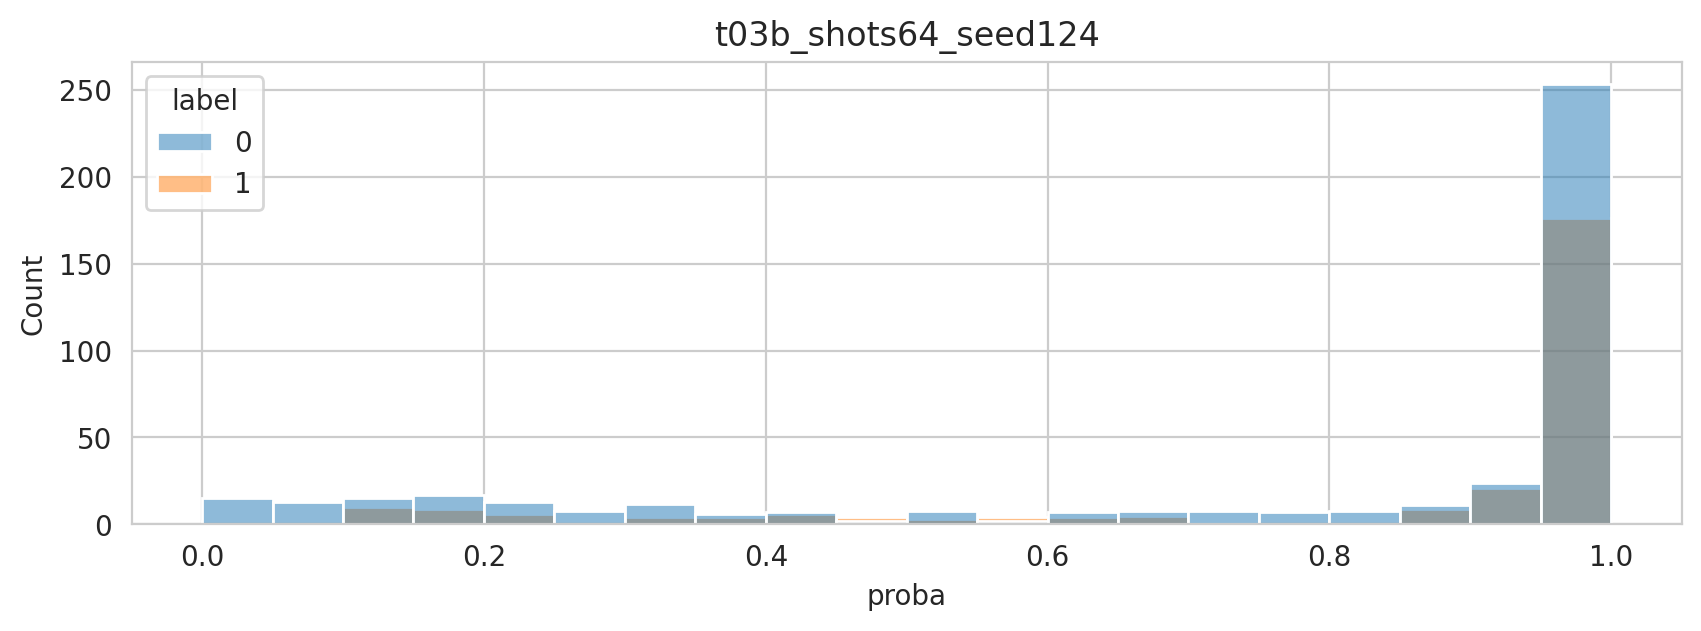

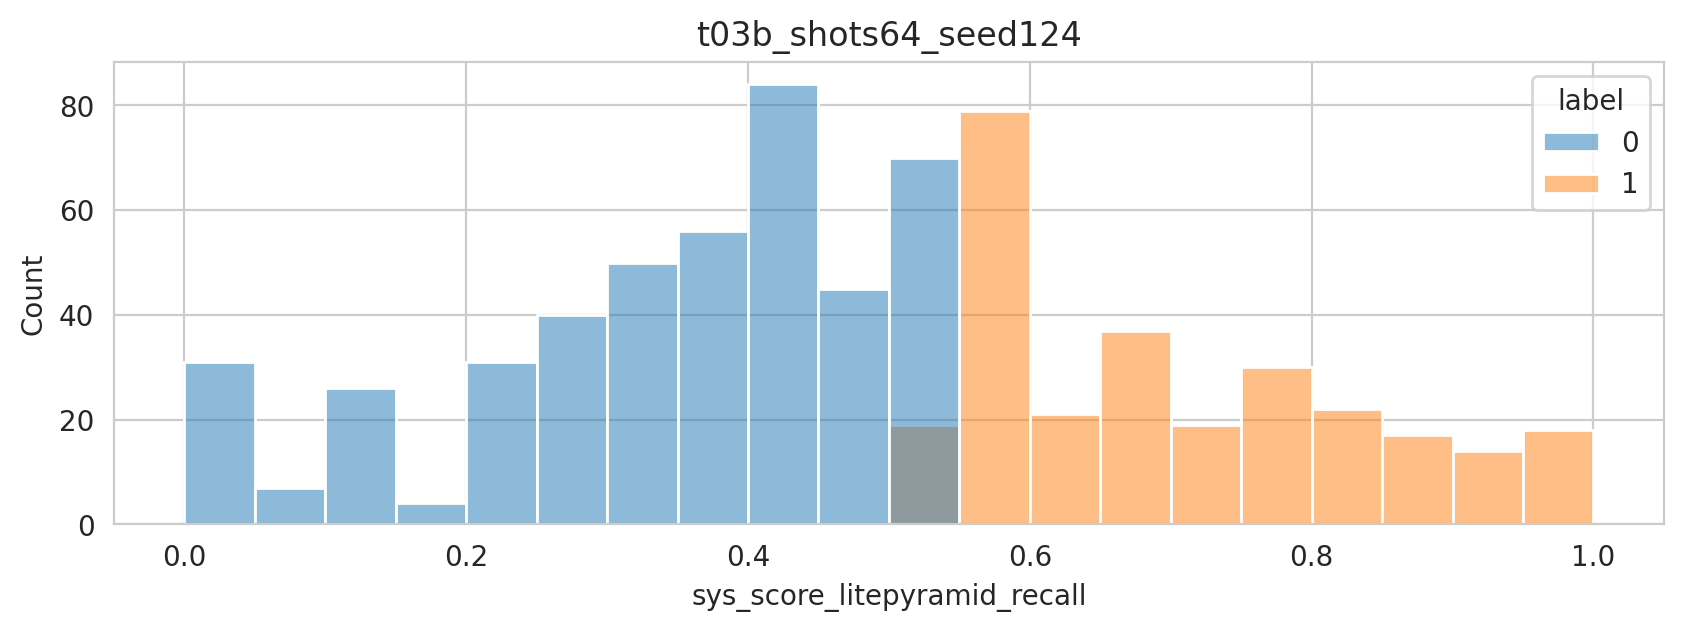

In [134]:
dev_exp_names = sorted(dev_shots.keys())


for exp_name in dev_exp_names[::10]:
    exp_values = dev_shots[exp_name]
    scores = np.exp(exp_values["log.scores_class_1"])
    exp_values["proba"] = scores
    
    plt.figure(figsize=(10, 3), dpi=200)
    sns.histplot(data=exp_values, x="proba", **hist_kwargs)
    plt.title(exp_name)
    plt.show()
    
    
    plt.figure(figsize=(10, 3), dpi=200)
    sns.histplot(data=exp_values, x="sys_score_litepyramid_recall", **hist_kwargs)
    plt.title(exp_name)
    plt.show()
    
    print("\n\n\n")

In [132]:
exp_values.columns

Index(['prediction', 'label', 'idx', 'log.score_gt', 'log.score_cand',
       'current_epoch', 'log.scores_class_0', 'log.scores_class_1', 'model',
       'num_shots', 'seed_shots', 'index', 'sys_name', 'bartscore_doc_id',
       'proba'],
      dtype='object')

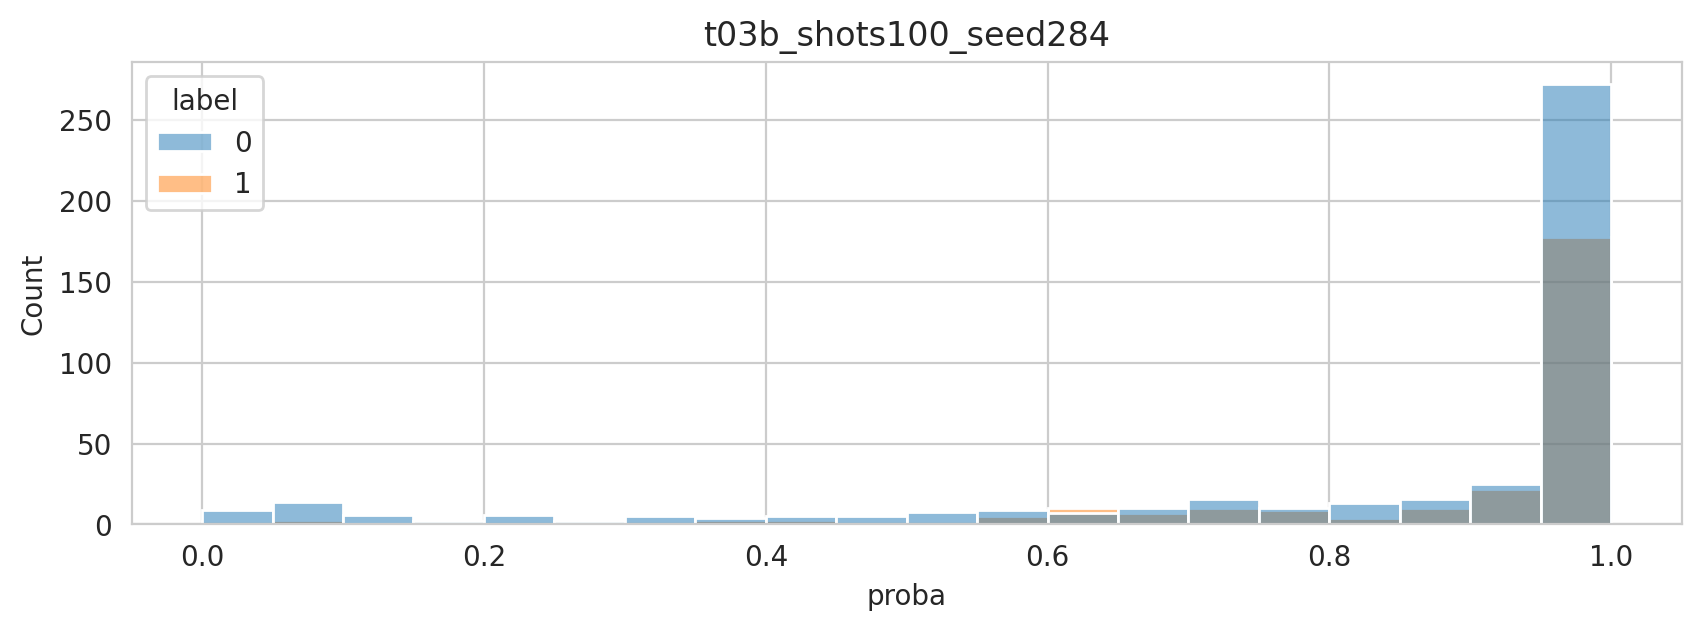

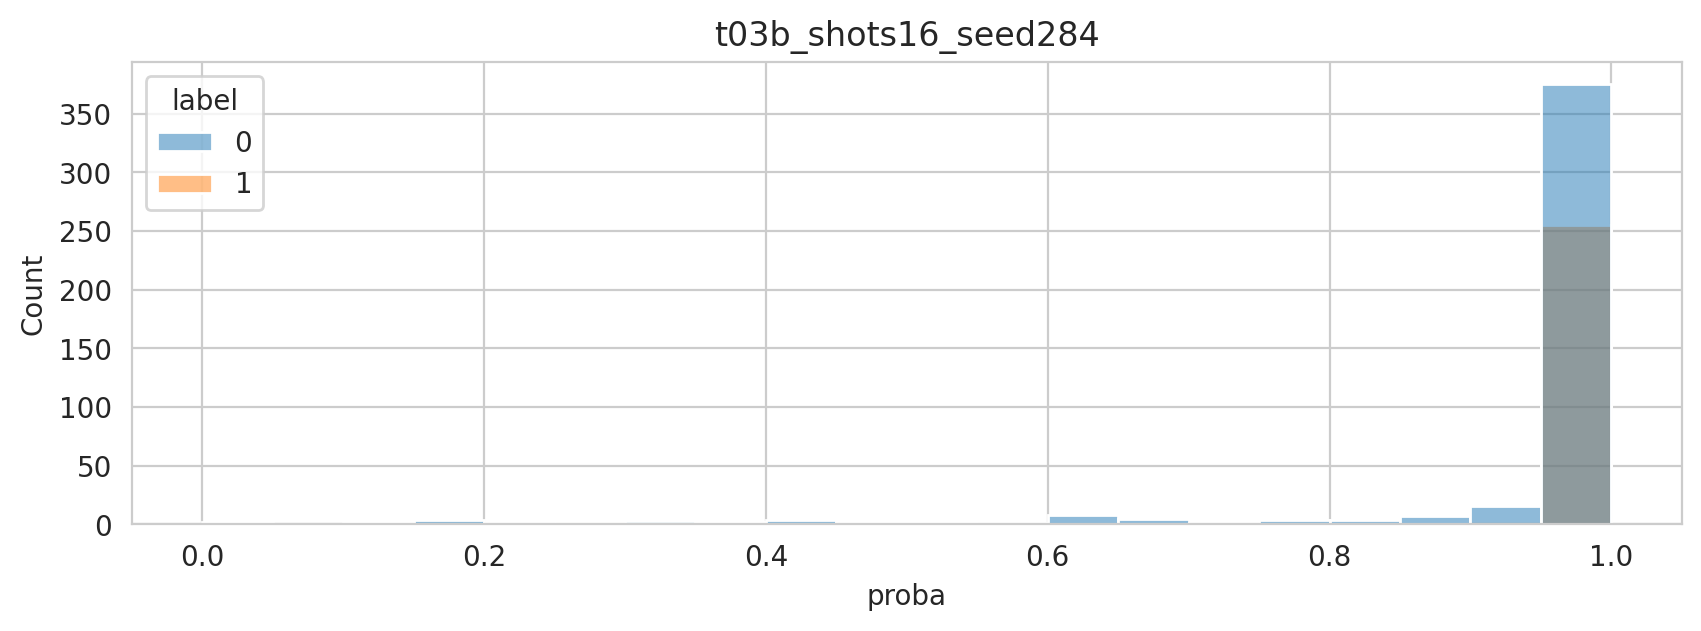

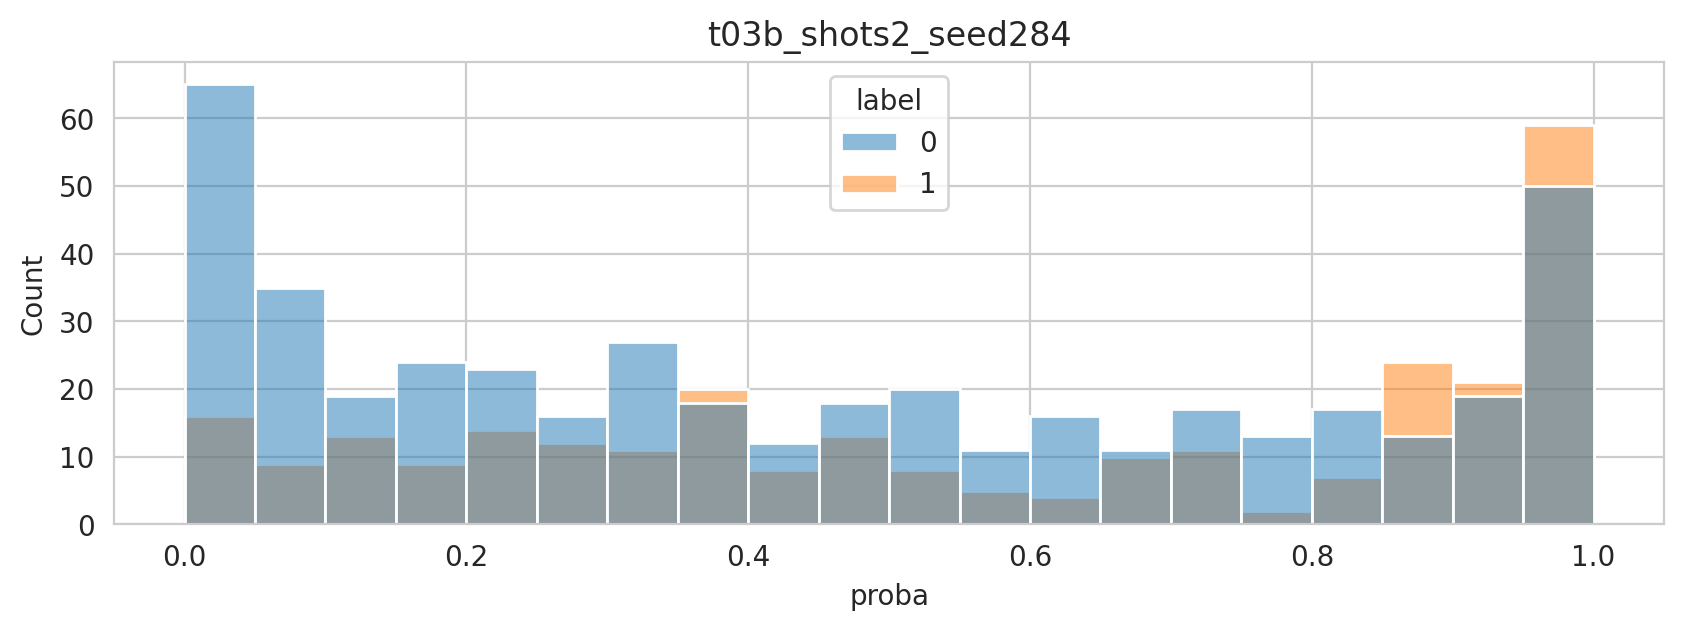

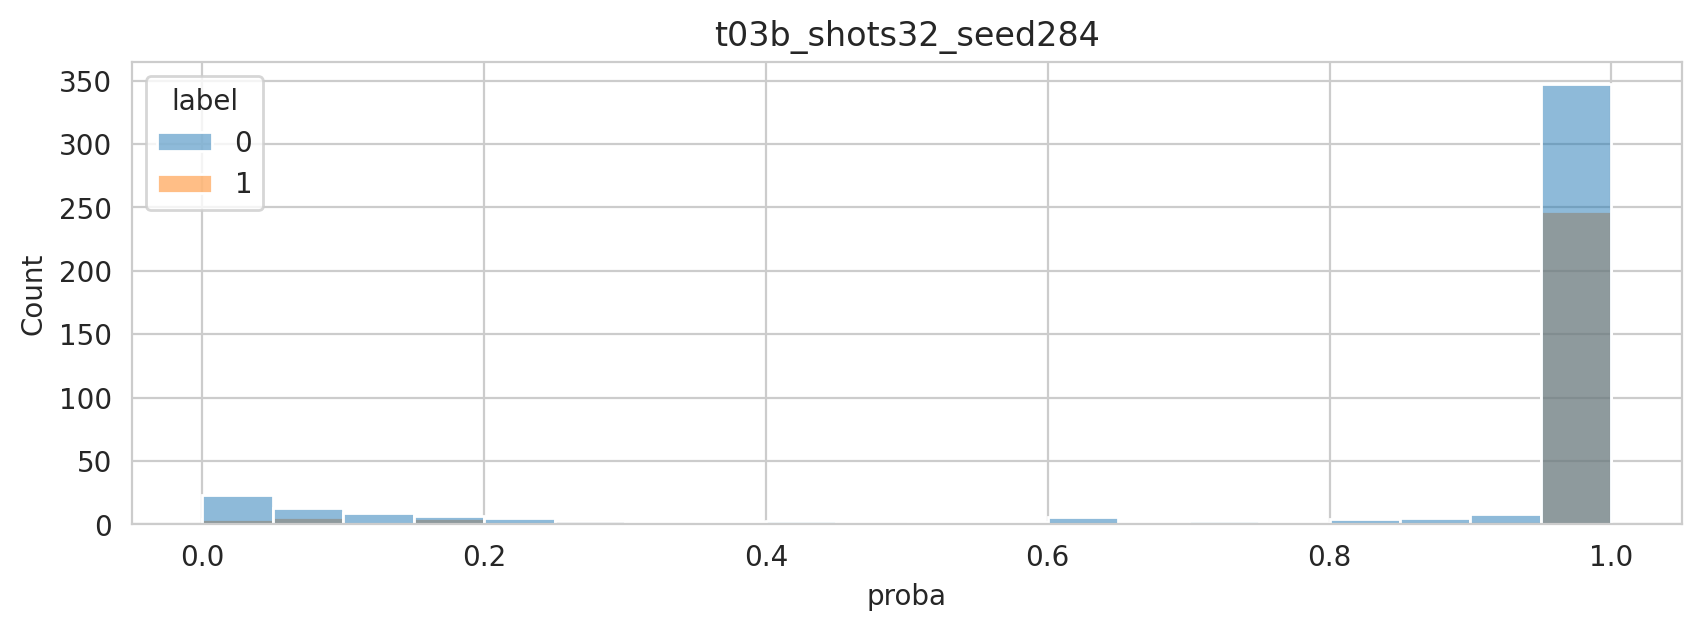

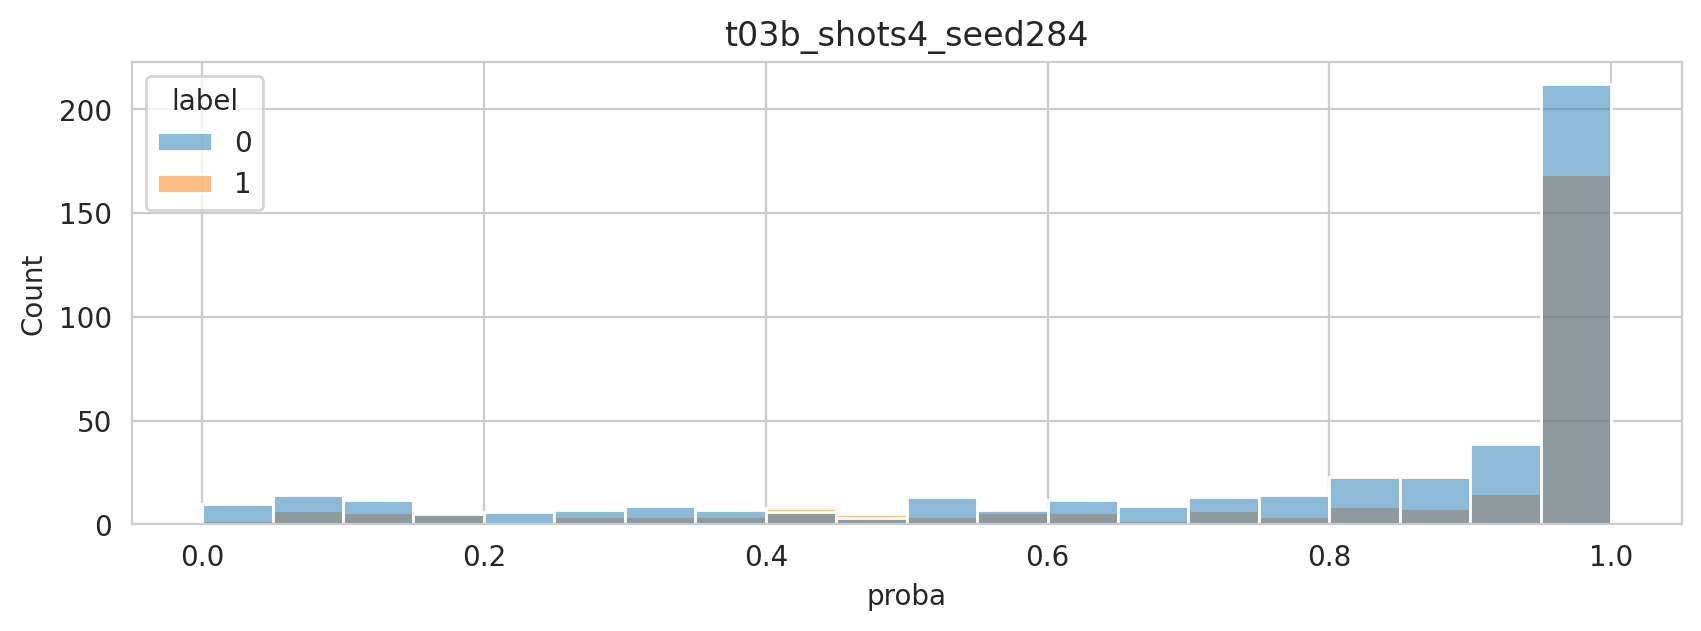

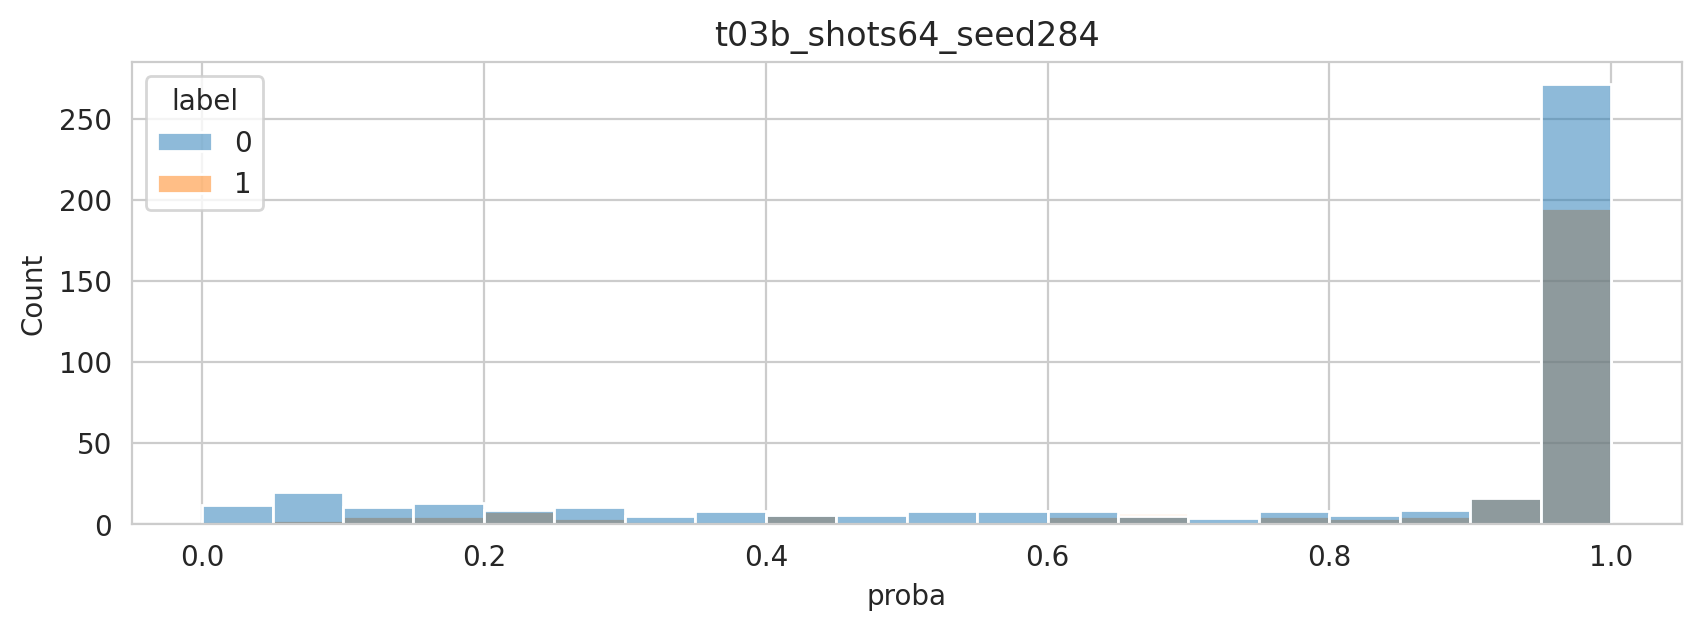

In [125]:
for exp_name in dev_exp_names[4::10]:
    exp_values = dev_shots[exp_name]
    scores = np.exp(exp_values["log.scores_class_1"])
    exp_values["proba"] = scores
    
    plt.figure(figsize=(10, 3), dpi=200)
    sns.histplot(data=exp_values, x="proba", **hist_kwargs)
    plt.title(exp_name)

In [109]:
dev_exp_names

['t03b_shots100_seed124',
 't03b_shots100_seed23',
 't03b_shots100_seed2315',
 't03b_shots100_seed23572',
 't03b_shots100_seed284',
 't03b_shots100_seed32',
 't03b_shots100_seed445',
 't03b_shots100_seed58',
 't03b_shots100_seed845',
 't03b_shots100_seed9273',
 't03b_shots16_seed124',
 't03b_shots16_seed23',
 't03b_shots16_seed2315',
 't03b_shots16_seed23572',
 't03b_shots16_seed284',
 't03b_shots16_seed32',
 't03b_shots16_seed445',
 't03b_shots16_seed58',
 't03b_shots16_seed845',
 't03b_shots16_seed9273',
 't03b_shots2_seed124',
 't03b_shots2_seed23',
 't03b_shots2_seed2315',
 't03b_shots2_seed23572',
 't03b_shots2_seed284',
 't03b_shots2_seed32',
 't03b_shots2_seed445',
 't03b_shots2_seed58',
 't03b_shots2_seed845',
 't03b_shots2_seed9273',
 't03b_shots32_seed124',
 't03b_shots32_seed23',
 't03b_shots32_seed2315',
 't03b_shots32_seed23572',
 't03b_shots32_seed284',
 't03b_shots32_seed32',
 't03b_shots32_seed445',
 't03b_shots32_seed58',
 't03b_shots32_seed845',
 't03b_shots32_seed927

<AxesSubplot:xlabel='log.scores_class_0', ylabel='log.scores_class_1'>

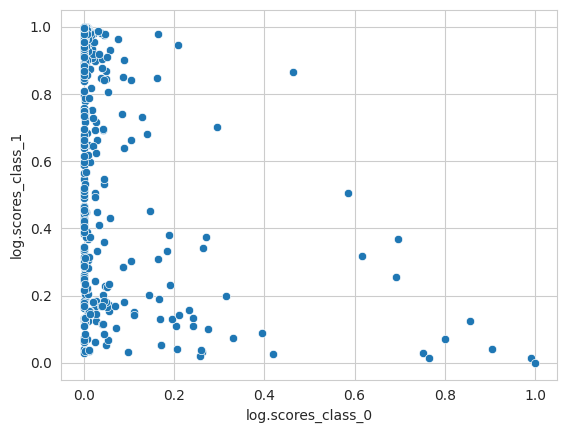

In [140]:
sns.scatterplot(x=np.exp(exp_values["log.scores_class_0"]), y=np.exp(exp_values["log.scores_class_1"]))

<AxesSubplot:ylabel='Frequency'>

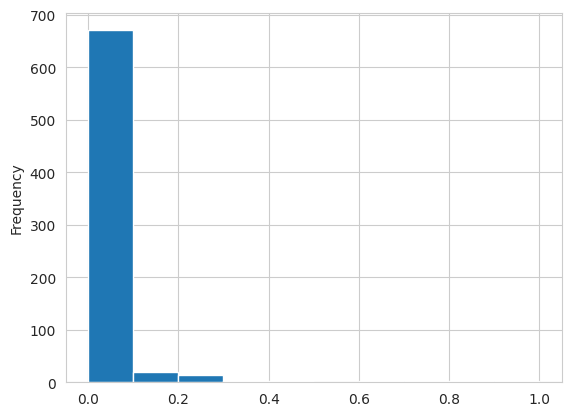

In [142]:
np.exp(exp_values["log.scores_class_0"]).plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

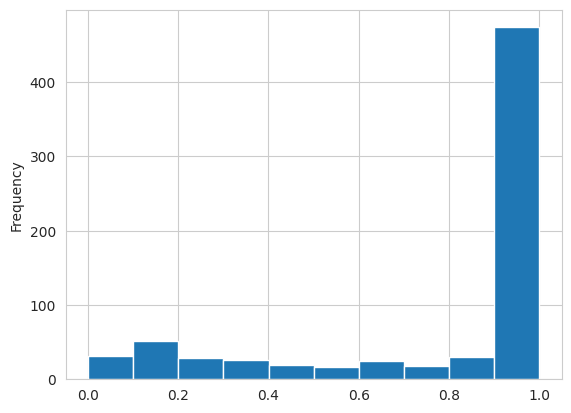

In [143]:
np.exp(exp_values["log.scores_class_1"]).plot(kind="hist")